CSCI E-82 - Advanced Machine Learning, Data Mining and Artificial Intelligence
=====

# Project - LSTM Classification Notebook

### *Dominic Murphy and David Modjeska*

------

# Introduction

In [1]:
import math
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

import tensorflow
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, LSTM, regularizers
from keras.optimizers import SGD, Adam
from keras import backend as K
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint, LearningRateScheduler ,ReduceLROnPlateau
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import metrics
from keras import regularizers

%matplotlib inline
from IPython.display import Image, display, HTML

Using TensorFlow backend.


In [2]:
def my_display(str): 
    display(HTML(str))
    
def my_display_df(df): 
    display(HTML(df.to_html(index=False)))
    
def my_linespace():
    my_display('<p>')
    
plt.rcParams["patch.force_edgecolor"] = True   
plt.style.use('ggplot')

palette = sns.color_palette(palette = 'deep')
sns.set_palette(palette)

# Modeling

*Note: some code has been adapted from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/*

#### Helper function to convert a dataframe for supervised learning

In [3]:
def series_to_supervised(data, n_in = 1, n_out = 1, drop_nan = True):
    columns = data.columns.values
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(columns[j] + '(t-%d)' % (i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(columns[j] + '(t)' % ()) for j in range(n_vars)]
        else:
            names += [(columns[j] + '(t+%d)' % (i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    # drop rows with NaN values
    if drop_nan:
        agg.dropna(inplace = True)
    
    return agg

#### Load data

In [4]:
data = pd.read_csv('source_data.csv', parse_dates = ['date_key'])
print(data.shape)

(6551, 151)


#### Display first few rows of data

In [5]:
data.head()

,date_dayofyear,date_key,date_month,date_qtr,AU_IS_WORK_DAY,US_IS_WORK_DAY,CA_IS_WORK_DAY,UK_IS_WORK_DAY,IS_EURO,AU_FX,...,UK_FX_MA_090,UK_FX_MA_180,UK_FX_MA_365,temperature,AU_BMP_Ratio,CA_BMP_Ratio,UK_BMP_Ratio,CH_BMP_Ratio,JP_BMP_Ratio,time_index
0,3,2000-01-03,1,1,0,1,1,0,1,0.6591,...,1.628023,1.617005,1.617082,-0.943863,0.680107,0.784969,1.231594,3.715825,1.151735,0
1,4,2000-01-04,1,1,1,1,1,0,1,0.6562,...,1.627812,1.617446,1.617025,-0.940453,0.677115,0.782104,1.239163,3.658705,1.136206,1
2,5,2000-01-05,1,1,1,1,1,1,1,0.6550,...,1.627695,1.617946,1.616983,-0.940453,0.675876,0.782104,1.242570,3.649538,1.128760,2
3,6,2000-01-06,1,1,1,1,1,1,1,0.6540,...,1.627645,1.618471,1.616963,-0.936941,0.674845,0.779259,1.247112,3.652829,1.113523,3
4,7,2000-01-07,1,1,1,1,1,1,1,0.6548,...,1.627491,1.618938,1.616933,-0.936941,0.675670,0.782805,1.240223,3.672339,1.113735,4


#### Extract feature columns

In [6]:
feature_data = data.drop(['date_key', 'time_index'], axis = 1)
feature_cols = feature_data.columns
n_feature_cols = feature_data.shape[1]

## Helper functions

#### Calculate the latest start date among a set of features

In [7]:
euro_start_date = '2000-01-03'

def get_start_row_index(data, col_names):
    return(max([data[col].isnull().idxmin() for col in col_names]))

#### Reduce dimensionality of X by PCA

In [8]:
def pca_X(currency_name, X):
    
    # fit a PCA for exploration only
    n_pcs_total = int(100)
    pca = PCA(n_components = n_pcs_total, svd_solver = 'full', random_state = 0)
    pca.fit(X)
    ratios = np.cumsum(pca.explained_variance_ratio_)
    
    # scree plot of variances explained
    plt.plot(1.0 - ratios)
    plt.title(currency_name + " - PCA cumulative variance explained")
    plt.xlabel("Number of components")
    plt.ylabel("% of variance not explained")
    plt.show()
    
    # computer number of components to use
    n_pcs_to_use = 40
    print('Cumulative variance explained by the first ' + str(n_pcs_to_use) + ' components: ' + 
          str(np.round(ratios[n_pcs_to_use], 4)))
    
    # fit a PCA and transform the data
    pca = PCA(n_components = n_pcs_to_use, svd_solver = 'arpack', random_state = 0)
    pca.fit(X)    
    X_pca = pd.DataFrame(pca.transform(X))
    
    return(X_pca, pca)

#### Helper function to manage data reduction by PCA

In [9]:
def do_pca_X(currency_name, do_pca, n_past_lags, this_data_reframed):
    if do_pca and (n_past_lags > 1):
        X = this_data_reframed.iloc[:, :-1]        
        X_pca, pca = pca_X(currency_name, X)
        this_data_pca = X_pca        
        this_data_pca['y'] = this_data_reframed.iloc[:, -1].values 

        my_display("<h4>Shape of train and test data after PCA</h4>")
        print('Reduced data shape: ' + str(this_data_pca.shape))
    else:
        this_data_pca = this_data_reframed
        pca = None
        
    return(this_data_pca, pca)

#### Helper function to reframe data for supervised training

In [10]:
def reframe_data(this_data_scaled, n_past_lags, n_future_lags, n_these_cols):
    this_data_reframed = series_to_supervised(this_data_scaled, n_past_lags, n_future_lags) # X, y, and extra
    this_data_reframed_past = this_data_reframed.iloc[:, :(n_past_lags*n_these_cols)] # X = past = predictor
    this_data_reframed_future = this_data_reframed.iloc[:, -n_these_cols] # y = future = response
    this_data_reframed = pd.concat([this_data_reframed_past, this_data_reframed_future], axis = 1) # X and y
    
    print('Reframed data shape: ' + str(this_data_reframed.shape))
    return(this_data_reframed)

#### Prepare data for one model

In [11]:
n_past_lags = 180
n_future_lags = 180

def prep_model_data(currency_name, col_names, do_pca = False, verbose = 2):
    my_display("<h3>Prepare model data</h3>")
    
    # extract untransformed data
    n_these_cols = len(col_names)
    start_row_index = get_start_row_index(data, col_names)
    this_data = data[col_names].iloc[start_row_index:, :]
    n_these_rows = this_data.shape[0]
    
    # print data's time period
    print("Time period: " + str(data.date_key.dt.date[0]) + ' - ' + 
          str(data.date_key.dt.date[n_these_rows - 1]))
    
    # list untransformed model features
    if not do_pca:
        my_display("<h4>Features in Model</h4>")
        print(*col_names, sep = ', ')
        print()
    
    # scale data
    scaler = MinMaxScaler(feature_range = (0, 1))
    this_data_scaled = pd.DataFrame(scaler.fit_transform(this_data))
    this_data_scaled.columns = col_names
    print('Scaled data shape: ' + str(this_data_scaled.shape))
    
    # reframe data for supervised training
    this_data_reframed = reframe_data(this_data_scaled, n_past_lags, n_future_lags, n_these_cols)
    
    # convert reframed data for classification
    last_col_name = this_data_reframed.columns[-1]
    this_data_reframed['Is_Up'] = \
        np.where(this_data_reframed.iloc[:, -1] - this_data_reframed.iloc[:, 0] > 0, 1, 0)
    this_data_reframed = this_data_reframed.drop(last_col_name, axis = 1)

    # PCA X (if needed)
    this_data_pca, pca = do_pca_X(currency_name, do_pca, n_past_lags, this_data_reframed)
    
    # display first few rows of supervised data
    if (verbose == 2 and not do_pca):
        my_display("<h4>First few rows of supervised data</h4>")
        my_linespace()
        my_display_df(this_data_pca.head())
        my_linespace()

    # predict y naively as a coin flip
    yhat_naive = pd.DataFrame(np.ones(this_data_pca.shape[0]) * 0.5)
        
    # split into train and test sets
    train, test, yhat_naive_train, yhat_naive_test = \
        train_test_split(this_data_pca, yhat_naive, test_size = 0.33, shuffle = False, random_state = 0)
    
    # split into input and outputs
    train_X, train_y = train.iloc[:, :-1], train.iloc[:, -1]
    test_X, test_y = test.iloc[:, :-1], test.iloc[:, -1]
    
    # reshape input to be 3D [samples, timesteps, features] (LSTM only)
    train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.values.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    if verbose == 2:
        my_display("<h4>Shape of train and test data</h4>")
        print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    return(train_X, test_X, train_y, test_y, scaler, pca, yhat_naive_test, n_these_cols)

In [12]:
# adapted from https://github.com/fchollet/keras/issues/5400

def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall))

In [13]:
# design network
def define_nn(train_X):
    model = Sequential()
    model.add(LSTM(200, input_shape = (train_X.shape[1], train_X.shape[2]),
                  bias_regularizer = regularizers.l2(0.002),
                  kernel_regularizer = regularizers.l2(0.002),
                  activity_regularizer = regularizers.l2(0.001)))
    model.add(Dropout(0.02))
    model.add(Dense(1, activation = 'sigmoid'))
    
    adam = Adam(lr = 0.01, epsilon = 1e-8)
    model.compile(loss = 'binary_crossentropy', optimizer = adam)
    return(model)

In [14]:
def step_decay(epoch):
    initial_lrate = 0.01
    lrate = initial_lrate / math.pow(epoch + 1, .5)
    return lrate

In [15]:
early_stop = EarlyStopping (monitor = 'val_loss', min_delta = .00001, patience = 50, 
                            verbose = 2, mode = 'auto')

In [16]:
def plot_lstm_history(history):
    print()
    fig = plt.figure(figsize = (8, 6))
    plt.plot(history.history['loss'], label = 'train')
    plt.plot(history.history['val_loss'], label = 'test')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()   

#### Helper function to instantiate and fit one model, and plot the feature importances

In [17]:
def define_fit_model(currency_name, train_X, test_X, train_y, test_y, do_pca = False, verbose = 2):
    my_display("<h3>Fit model</h3>") 
    
    n_epochs = 200    
    reduce_lr = LearningRateScheduler(step_decay)
    model_checkpoint = ModelCheckpoint(filepath = "./best_model.hdf5", monitor = 'val_loss', 
                                       verbose = 2, save_best_only = True, 
                                       save_weights_only = True, mode = 'auto', period = 1)
   
    # fit model
    model = define_nn(train_X)    
    history = model.fit(train_X, train_y, epochs = n_epochs, batch_size = 32, 
                        validation_data = (test_X, test_y), verbose = verbose, shuffle = False,
                       callbacks = [reduce_lr, model_checkpoint, early_stop])
    
    # plot training history
    if verbose == 2:       
        plot_lstm_history(history)
        
    return(model)

#### Helper function to inverse transform the data

In [18]:
def inverse_transform(y, X, scaler, pca, n_cols):
    if pca is not None:
        X = pca.inverse_transform(X)
    else:
        X = X.values
        
    inv_y = np.concatenate((y, X[:, 1:n_cols]), axis = 1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]
    
    return(inv_y)

#### Helper function to plot ROC AUC curve

In [19]:
# adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def display_roc_curve(y, predict_y_proba):
   
    fp_rate1, tp_rate1, _ = roc_curve(y, predict_y_proba)
    roc_auc1 = auc(fp_rate1, tp_rate1)

    print()
    plt.figure(figsize = (4.5, 4.5))
    plt.title('ROC Curve (Class = 1)')
    
    plt.plot(fp_rate1, tp_rate1, 'b',
    label='AUC = %0.3f'% roc_auc1)
    plt.legend(loc='lower right')
    
    plt.plot([0,1],[0,1],'r--', lw = 1)
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    plt.show()

#### Score a model with test data

In [20]:
no_score = None

def score_model(currency_name, best_model, train_X, test_X, train_y, test_y, scaler, pca, 
                inv_yhat_naive, n_cols, verbose = 2):
    my_display("<h3>Score model on test data</h3>")
    
    # reload best model (LSTM only)
    best_model = define_nn(train_X)
    best_model.load_weights('./best_model.hdf5')
    
    # make a prediction on test data
    this_X = test_X
    yhat = best_model.predict_proba(this_X).reshape(-1, 1)
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

    # invert/reverse/undo scaling for forecast
    inv_yhat = yhat
    
    # invert scaling for actual
    test_y = test_y.values.reshape((len(test_y), 1))
    inv_y = test_y
    
    # invert scaling for y-hat naive
    inv_yhat_naive = inv_yhat_naive.values.reshape((len(inv_yhat_naive), 1))     
    
    # naive model
    my_display("<h4>AUC from naive model that flips a coin</h4>")
    naive_score = roc_auc_score(inv_y, inv_yhat_naive)
    print("AUC: " + str(np.round(naive_score, 5)))
    
    # calculate RMSE on test data
    my_display("<h4>AUC from fitted model</h4>")
    test_score = roc_auc_score(inv_y, inv_yhat)
    print("AUC: " + str(np.round(test_score, 5)))
    
    if verbose == 2 and pca is None:
        display_roc_curve(inv_y, inv_yhat)
    
    return(naive_score, test_score)

#### Top-level function to create, fit, and score one model

In [21]:
def do_one_model(currency_name, feature_col_names, do_pca = False, verbose = 2):
    if do_pca:
        return(0.5, None)
    
    train_X, test_X, train_y, test_y, scaler, pca, yhat_naive_test, n_features = \
        prep_model_data(currency_name, feature_col_names, do_pca, verbose)
    best_model = define_fit_model(currency_name, train_X, test_X, train_y, test_y, do_pca, verbose)
    naive_score, test_score = score_model(currency_name, best_model, train_X, test_X, train_y, test_y,
                                          scaler, pca, 
                                        yhat_naive_test, n_features, verbose = verbose)
    
    return(naive_score, test_score)

#### Create a dataframe to accumulate modeling results for all currencies

In [22]:
all_results = pd.DataFrame()

#### Accumulate results from one model

In [23]:
def accum_results(all_results, currency, naive_score, fx_auc, fx_features_auc, fx_all_auc):
    results = pd.DataFrame({'Currency': currency, 
                              'Naive': naive_score, 
                              'FX Only': fx_auc, 
                              'FX + Features': fx_features_auc,
                              'All Features': fx_all_auc},
                            index = range(1))
    all_results = all_results.append(results).reset_index(drop = True)
    return(all_results)

## Australia

### FX rates only

Time period: 2000-01-03 - 2017-12-09


AU_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6192, 181)


AU_FX(t-180),AU_FX(t-179),AU_FX(t-178),AU_FX(t-177),AU_FX(t-176),AU_FX(t-175),AU_FX(t-174),AU_FX(t-173),AU_FX(t-172),AU_FX(t-171),AU_FX(t-170),AU_FX(t-169),AU_FX(t-168),AU_FX(t-167),AU_FX(t-166),AU_FX(t-165),AU_FX(t-164),AU_FX(t-163),AU_FX(t-162),AU_FX(t-161),AU_FX(t-160),AU_FX(t-159),AU_FX(t-158),AU_FX(t-157),AU_FX(t-156),AU_FX(t-155),AU_FX(t-154),AU_FX(t-153),AU_FX(t-152),AU_FX(t-151),AU_FX(t-150),AU_FX(t-149),AU_FX(t-148),AU_FX(t-147),AU_FX(t-146),AU_FX(t-145),AU_FX(t-144),AU_FX(t-143),AU_FX(t-142),AU_FX(t-141),AU_FX(t-140),AU_FX(t-139),AU_FX(t-138),AU_FX(t-137),AU_FX(t-136),AU_FX(t-135),AU_FX(t-134),AU_FX(t-133),AU_FX(t-132),AU_FX(t-131),AU_FX(t-130),AU_FX(t-129),AU_FX(t-128),AU_FX(t-127),AU_FX(t-126),AU_FX(t-125),AU_FX(t-124),AU_FX(t-123),AU_FX(t-122),AU_FX(t-121),AU_FX(t-120),AU_FX(t-119),AU_FX(t-118),AU_FX(t-117),AU_FX(t-116),AU_FX(t-115),AU_FX(t-114),AU_FX(t-113),AU_FX(t-112),AU_FX(t-111),AU_FX(t-110),AU_FX(t-109),AU_FX(t-108),AU_FX(t-107),AU_FX(t-106),AU_FX(t-105),AU_FX(t-104),AU_FX(t-103),AU_FX(t-102),AU_FX(t-101),AU_FX(t-100),AU_FX(t-99),AU_FX(t-98),AU_FX(t-97),AU_FX(t-96),AU_FX(t-95),AU_FX(t-94),AU_FX(t-93),AU_FX(t-92),AU_FX(t-91),AU_FX(t-90),AU_FX(t-89),AU_FX(t-88),AU_FX(t-87),AU_FX(t-86),AU_FX(t-85),AU_FX(t-84),AU_FX(t-83),AU_FX(t-82),AU_FX(t-81),AU_FX(t-80),AU_FX(t-79),AU_FX(t-78),AU_FX(t-77),AU_FX(t-76),AU_FX(t-75),AU_FX(t-74),AU_FX(t-73),AU_FX(t-72),AU_FX(t-71),AU_FX(t-70),AU_FX(t-69),AU_FX(t-68),AU_FX(t-67),AU_FX(t-66),AU_FX(t-65),AU_FX(t-64),AU_FX(t-63),AU_FX(t-62),AU_FX(t-61),AU_FX(t-60),AU_FX(t-59),AU_FX(t-58),AU_FX(t-57),AU_FX(t-56),AU_FX(t-55),AU_FX(t-54),AU_FX(t-53),AU_FX(t-52),AU_FX(t-51),AU_FX(t-50),AU_FX(t-49),AU_FX(t-48),AU_FX(t-47),AU_FX(t-46),AU_FX(t-45),AU_FX(t-44),AU_FX(t-43),AU_FX(t-42),AU_FX(t-41),AU_FX(t-40),AU_FX(t-39),AU_FX(t-38),AU_FX(t-37),AU_FX(t-36),AU_FX(t-35),AU_FX(t-34),AU_FX(t-33),AU_FX(t-32),AU_FX(t-31),AU_FX(t-30),AU_FX(t-29),AU_FX(t-28),AU_FX(t-27),AU_FX(t-26),AU_FX(t-25),AU_FX(t-24),AU_FX(t-23),AU_FX(t-22),AU_FX(t-21),AU_FX(t-20),AU_FX(t-19),AU_FX(t-18),AU_FX(t-17),AU_FX(t-16),AU_FX(t-15),AU_FX(t-14),AU_FX(t-13),AU_FX(t-12),AU_FX(t-11),AU_FX(t-10),AU_FX(t-9),AU_FX(t-8),AU_FX(t-7),AU_FX(t-6),AU_FX(t-5),AU_FX(t-4),AU_FX(t-3),AU_FX(t-2),AU_FX(t-1),Is_Up
0.284447,0.279768,0.277832,0.276218,0.277509,0.278208,0.278907,0.279606,0.281865,0.282349,0.299935,0.296386,0.295714,0.295041,0.294369,0.292352,0.291384,0.296547,0.289287,0.285146,0.281005,0.276864,0.276541,0.270571,0.277832,0.231849,0.238141,0.244434,0.250726,0.239916,0.247177,0.251533,0.239916,0.241207,0.242498,0.243788,0.246047,0.244756,0.240723,0.234592,0.234430,0.234269,0.234108,0.237496,0.237657,0.240723,0.236205,0.235264,0.234323,0.233382,0.230558,0.220716,0.212327,0.217328,0.214155,0.210982,0.207809,0.214101,0.199903,0.201517,0.202323,0.198774,0.195224,0.191675,0.194740,0.204259,0.214101,0.211036,0.212595,0.214155,0.215715,0.211681,0.209261,0.206357,0.199903,0.199796,0.199688,0.199581,0.205227,0.198128,0.195708,0.199419,0.202108,0.204797,0.207486,0.211843,0.209100,0.209261,0.199096,0.199688,0.200280,0.200871,0.194256,0.197644,0.191675,0.189577,0.188932,0.188287,0.187641,0.182156,0.184253,0.183124,0.184576,0.181403,0.178230,0.175056,0.180381,0.182156,0.177961,0.176993,0.178068,0.179144,0.180219,0.181994,0.171346,0.168925,0.162794,0.160805,0.158815,0.156825,0.166021,0.172959,0.175218,0.178606,0.175110,0.171614,0.168119,0.161342,0.159245,0.155211,0.158438,0.154620,0.150801,0.146983,0.152469,0.138270,0.141175,0.145208,0.145854,0.146499,0.147144,0.148274,0.142788,0.140691,0.143272,0.144670,0.146069,0.147467,0.151662,0.141981,0.144079,0.155211,0.156395,0.157578,0.158761,0.170862,0.172959,0.169409,0.167151,0.169732,0.172314,0.174895,0.184737,0.190223,0.191513,0.202485,0.199312,0.196139,0.192965,0.195063,0.193288,0.187964,0.183285,0.183339,0.183392,0.183446,0.191029,0.192804,0.193772,0.184414,0
0.279768,0.277832,0.276218,0.277509,0.278208,0.278907,0.279606,0.281865,0.282349,0.299935,0.296386,0.295714,0.295041,0.294369,0.292352,0.291

(4148, 1, 180) (4148,) (2044, 1, 180) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
Epoch 00000: val_loss improved from inf to 2.17302, saving model to ./best_model.hdf5
1s - loss: 1.1373 - val_loss: 2.1730
Epoch 2/200
Epoch 00001: val_loss improved from 2.17302 to 2.09762, saving model to ./best_model.hdf5
1s - loss: 1.0634 - val_loss: 2.0976
Epoch 3/200
Epoch 00002: val_loss improved from 2.09762 to 1.71069, saving model to ./best_model.hdf5
1s - loss: 1.0620 - val_loss: 1.7107
Epoch 4/200
Epoch 00003: val_loss did not improve
1s - loss: 0.9601 - val_loss: 1.7787
Epoch 5/200
Epoch 00004: val_loss improved from 1.71069 to 1.37078, saving model to ./best_model.hdf5
1s - loss: 0.9708 - val_loss: 1.3708
Epoch 6/200
Epoch 00005: val_loss improved from 1.37078 to 1.34835, saving model to ./best_model.hdf5
1s - loss: 0.9248 - val_loss: 1.3484
Epoch 7/200
Epoch 00006: val_loss improved from 1.34835 to 1.18050, saving model to ./best_model.hdf5
1s - loss: 0.8822 - val_loss: 1.1805
Epoch 8/200
Epoch 00007: val_loss d

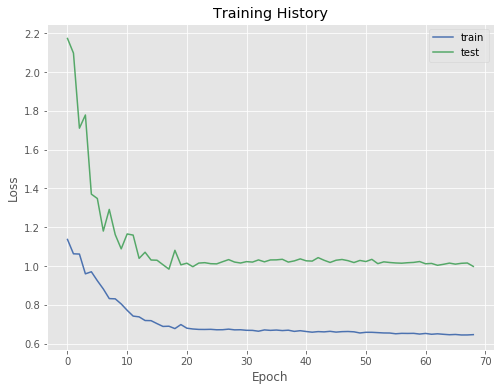

1088/2044 [==============>...............] - ETA: 0s

AUC: 0.5


AUC: 0.74067



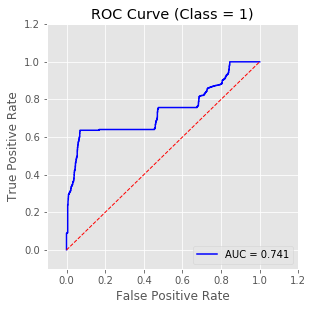

In [24]:
naive_score, fx_auc = do_one_model('AUD', feature_col_names = ['AU_FX'], verbose = 2)

### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


AU_FX, AU_BMP_Ratio

Scaled data shape: (6551, 2)
Reframed data shape: (6192, 361)


AU_FX(t-180),AU_BMP_Ratio(t-180),AU_FX(t-179),AU_BMP_Ratio(t-179),AU_FX(t-178),AU_BMP_Ratio(t-178),AU_FX(t-177),AU_BMP_Ratio(t-177),AU_FX(t-176),AU_BMP_Ratio(t-176),AU_FX(t-175),AU_BMP_Ratio(t-175),AU_FX(t-174),AU_BMP_Ratio(t-174),AU_FX(t-173),AU_BMP_Ratio(t-173),AU_FX(t-172),AU_BMP_Ratio(t-172),AU_FX(t-171),AU_BMP_Ratio(t-171),AU_FX(t-170),AU_BMP_Ratio(t-170),AU_FX(t-169),AU_BMP_Ratio(t-169),AU_FX(t-168),AU_BMP_Ratio(t-168),AU_FX(t-167),AU_BMP_Ratio(t-167),AU_FX(t-166),AU_BMP_Ratio(t-166),AU_FX(t-165),AU_BMP_Ratio(t-165),AU_FX(t-164),AU_BMP_Ratio(t-164),AU_FX(t-163),AU_BMP_Ratio(t-163),AU_FX(t-162),AU_BMP_Ratio(t-162),AU_FX(t-161),AU_BMP_Ratio(t-161),AU_FX(t-160),AU_BMP_Ratio(t-160),AU_FX(t-159),AU_BMP_Ratio(t-159),AU_FX(t-158),AU_BMP_Ratio(t-158),AU_FX(t-157),AU_BMP_Ratio(t-157),AU_FX(t-156),AU_BMP_Ratio(t-156),AU_FX(t-155),AU_BMP_Ratio(t-155),AU_FX(t-154),AU_BMP_Ratio(t-154),AU_FX(t-153),AU_BMP_Ratio(t-153),AU_FX(t-152),AU_BMP_Ratio(t-152),AU_FX(t-151),AU_BMP_Ratio(t-151),AU_FX(t-150),AU_BMP_Ratio(t-150),AU_FX(t-149),AU_BMP_Ratio(t-149),AU_FX(t-148),AU_BMP_Ratio(t-148),AU_FX(t-147),AU_BMP_Ratio(t-147),AU_FX(t-146),AU_BMP_Ratio(t-146),AU_FX(t-145),AU_BMP_Ratio(t-145),AU_FX(t-144),AU_BMP_Ratio(t-144),AU_FX(t-143),AU_BMP_Ratio(t-143),AU_FX(t-142),AU_BMP_Ratio(t-142),AU_FX(t-141),AU_BMP_Ratio(t-141),AU_FX(t-140),AU_BMP_Ratio(t-140),AU_FX(t-139),AU_BMP_Ratio(t-139),AU_FX(t-138),AU_BMP_Ratio(t-138),AU_FX(t-137),AU_BMP_Ratio(t-137),AU_FX(t-136),AU_BMP_Ratio(t-136),AU_FX(t-135),AU_BMP_Ratio(t-135),AU_FX(t-134),AU_BMP_Ratio(t-134),AU_FX(t-133),AU_BMP_Ratio(t-133),AU_FX(t-132),AU_BMP_Ratio(t-132),AU_FX(t-131),AU_BMP_Ratio(t-131),AU_FX(t-130),AU_BMP_Ratio(t-130),AU_FX(t-129),AU_BMP_Ratio(t-129),AU_FX(t-128),AU_BMP_Ratio(t-128),AU_FX(t-127),AU_BMP_Ratio(t-127),AU_FX(t-126),AU_BMP_Ratio(t-126),AU_FX(t-125),AU_BMP_Ratio(t-125),AU_FX(t-124),AU_BMP_Ratio(t-124),AU_FX(t-123),AU_BMP_Ratio(t-123),AU_FX(t-122),AU_BMP_Ratio(t-122),AU_FX(t-121),AU_BMP_Ratio(t-121),AU_FX(t-120),AU_BMP_Ratio(t-120),AU_FX(t-119),AU_BMP_Ratio(t-119),AU_FX(t-118),AU_BMP_Ratio(t-118),AU_FX(t-117),AU_BMP_Ratio(t-117),AU_FX(t-116),AU_BMP_Ratio(t-116),AU_FX(t-115),AU_BMP_Ratio(t-115),AU_FX(t-114),AU_BMP_Ratio(t-114),AU_FX(t-113),AU_BMP_Ratio(t-113),AU_FX(t-112),AU_BMP_Ratio(t-112),AU_FX(t-111),AU_BMP_Ratio(t-111),AU_FX(t-110),AU_BMP_Ratio(t-110),AU_FX(t-109),AU_BMP_Ratio(t-109),AU_FX(t-108),AU_BMP_Ratio(t-108),AU_FX(t-107),AU_BMP_Ratio(t-107),AU_FX(t-106),AU_BMP_Ratio(t-106),AU_FX(t-105),AU_BMP_Ratio(t-105),AU_FX(t-104),AU_BMP_Ratio(t-104),AU_FX(t-103),AU_BMP_Ratio(t-103),AU_FX(t-102),AU_BMP_Ratio(t-102),AU_FX(t-101),AU_BMP_Ratio(t-101),AU_FX(t-100),AU_BMP_Ratio(t-100),AU_FX(t-99),AU_BMP_Ratio(t-99),AU_FX(t-98),AU_BMP_Ratio(t-98),AU_FX(t-97),AU_BMP_Ratio(t-97),AU_FX(t-96),AU_BMP_Ratio(t-96),AU_FX(t-95),AU_BMP_Ratio(t-95),AU_FX(t-94),AU_BMP_Ratio(t-94),AU_FX(t-93),AU_BMP_Ratio(t-93),AU_FX(t-92),AU_BMP_Ratio(t-92),AU_FX(t-91),AU_BMP_Ratio(t-91),AU_FX(t-90),AU_BMP_Ratio(t-90),AU_FX(t-89),AU_BMP_Ratio(t-89),AU_FX(t-88),AU_BMP_Ratio(t-88),AU_FX(t-87),AU_BMP_Ratio(t-87),AU_FX(t-86),AU_BMP_Ratio(t-86),AU_FX(t-85),AU_BMP_Ratio(t-85),AU_FX(t-84),AU_BMP_Ratio(t-84),AU_FX(t-83),AU_BMP_Ratio(t-83),AU_FX(t-82),AU_BMP_Ratio(t-82),AU_FX(t-81),AU_BMP_Ratio(t-81),AU_FX(t-80),AU_BMP_Ratio(t-80),AU_FX(t-79),AU_BMP_Ratio(t-79),AU_FX(t-78),AU_BMP_Ratio(t-78),AU_FX(t-77),AU_BMP_Ratio(t-77),AU_FX(t-76),AU_BMP_Ratio(t-76),AU_FX(t-75),AU_BMP_Ratio(t-75),AU_FX(t-74),AU_BMP_Ratio(t-74),AU_FX(t-73),AU_BMP_Ratio(t-73),AU_FX(t-72),AU_BMP_Ratio(t-72),AU_FX(t-71),AU_BMP_Ratio(t-71),AU_FX(t-70),AU_BMP_Ratio(t-70),AU_FX(t-69),AU_BMP_Ratio(t-69),AU_FX(t-68),AU_BMP_Ratio(t-68),AU_FX(t-67),AU_BMP_Ratio(t-67),AU_FX(t-66),AU_BMP_Ratio(t-66),AU_FX(t-65),AU_BMP_Ratio(t-65),AU_FX(t-64),AU_BMP_Ratio(t-64),AU_FX(t-63),AU_BMP_Ratio(t-63),AU_FX(t-62),AU_BMP_Ratio(t-62),AU_FX(t-61),AU_BMP_Ratio(t-61),AU_FX(t-60),AU_BMP_Ratio(t-60),AU_FX(t-59),AU_BMP_Ratio(t-59),AU_FX(t-58),AU_BMP_Ratio(t-58),AU_FX(t-57),AU_BMP_Ratio(

(4148, 1, 360) (4148,) (2044, 1, 360) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
Epoch 00000: val_loss improved from inf to 1.95649, saving model to ./best_model.hdf5
1s - loss: 1.2974 - val_loss: 1.9565
Epoch 2/200
Epoch 00001: val_loss did not improve
1s - loss: 1.2949 - val_loss: 3.0061
Epoch 3/200
Epoch 00002: val_loss did not improve
1s - loss: 1.1782 - val_loss: 2.0041
Epoch 4/200
Epoch 00003: val_loss did not improve
1s - loss: 1.2173 - val_loss: 2.3812
Epoch 5/200
Epoch 00004: val_loss did not improve
1s - loss: 1.0457 - val_loss: 2.1288
Epoch 6/200
Epoch 00005: val_loss improved from 1.95649 to 1.32123, saving model to ./best_model.hdf5
1s - loss: 0.9745 - val_loss: 1.3212
Epoch 7/200
Epoch 00006: val_loss did not improve
1s - loss: 0.9314 - val_loss: 1.4859
Epoch 8/200
Epoch 00007: val_loss did not improve
1s - loss: 0.8918 - val_loss: 1.5119
Epoch 9/200
Epoch 00008: val_loss did not improve
1s - loss: 0.9026 - val_loss: 1.4149
Epoch 10/200
Epoch 00009: val_loss improved from 1.32123 to 1.02614, 

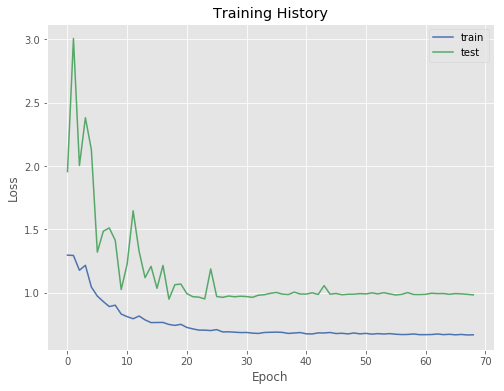

1056/2044 [==============>...............] - ETA: 0s

AUC: 0.5


AUC: 0.70942



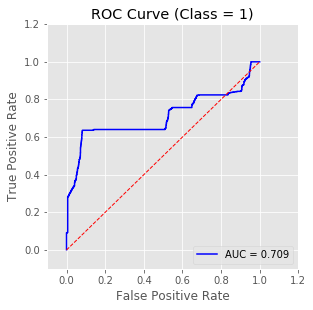

In [25]:
naive_score, fx_features_auc = do_one_model('AUD', feature_col_names = ['AU_FX', 'AU_BMP_Ratio'])

### All features

In [26]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('AU_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('AUD', feature_col_names = ['AU_FX'] + cols, do_pca = True)

In [27]:
all_results = accum_results(all_results, 'AUD', naive_score, fx_auc, fx_features_auc, fx_all_auc)

## Canada

### FX rates only

Time period: 2000-01-03 - 2017-12-09


CA_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6192, 181)


CA_FX(t-180),CA_FX(t-179),CA_FX(t-178),CA_FX(t-177),CA_FX(t-176),CA_FX(t-175),CA_FX(t-174),CA_FX(t-173),CA_FX(t-172),CA_FX(t-171),CA_FX(t-170),CA_FX(t-169),CA_FX(t-168),CA_FX(t-167),CA_FX(t-166),CA_FX(t-165),CA_FX(t-164),CA_FX(t-163),CA_FX(t-162),CA_FX(t-161),CA_FX(t-160),CA_FX(t-159),CA_FX(t-158),CA_FX(t-157),CA_FX(t-156),CA_FX(t-155),CA_FX(t-154),CA_FX(t-153),CA_FX(t-152),CA_FX(t-151),CA_FX(t-150),CA_FX(t-149),CA_FX(t-148),CA_FX(t-147),CA_FX(t-146),CA_FX(t-145),CA_FX(t-144),CA_FX(t-143),CA_FX(t-142),CA_FX(t-141),CA_FX(t-140),CA_FX(t-139),CA_FX(t-138),CA_FX(t-137),CA_FX(t-136),CA_FX(t-135),CA_FX(t-134),CA_FX(t-133),CA_FX(t-132),CA_FX(t-131),CA_FX(t-130),CA_FX(t-129),CA_FX(t-128),CA_FX(t-127),CA_FX(t-126),CA_FX(t-125),CA_FX(t-124),CA_FX(t-123),CA_FX(t-122),CA_FX(t-121),CA_FX(t-120),CA_FX(t-119),CA_FX(t-118),CA_FX(t-117),CA_FX(t-116),CA_FX(t-115),CA_FX(t-114),CA_FX(t-113),CA_FX(t-112),CA_FX(t-111),CA_FX(t-110),CA_FX(t-109),CA_FX(t-108),CA_FX(t-107),CA_FX(t-106),CA_FX(t-105),CA_FX(t-104),CA_FX(t-103),CA_FX(t-102),CA_FX(t-101),CA_FX(t-100),CA_FX(t-99),CA_FX(t-98),CA_FX(t-97),CA_FX(t-96),CA_FX(t-95),CA_FX(t-94),CA_FX(t-93),CA_FX(t-92),CA_FX(t-91),CA_FX(t-90),CA_FX(t-89),CA_FX(t-88),CA_FX(t-87),CA_FX(t-86),CA_FX(t-85),CA_FX(t-84),CA_FX(t-83),CA_FX(t-82),CA_FX(t-81),CA_FX(t-80),CA_FX(t-79),CA_FX(t-78),CA_FX(t-77),CA_FX(t-76),CA_FX(t-75),CA_FX(t-74),CA_FX(t-73),CA_FX(t-72),CA_FX(t-71),CA_FX(t-70),CA_FX(t-69),CA_FX(t-68),CA_FX(t-67),CA_FX(t-66),CA_FX(t-65),CA_FX(t-64),CA_FX(t-63),CA_FX(t-62),CA_FX(t-61),CA_FX(t-60),CA_FX(t-59),CA_FX(t-58),CA_FX(t-57),CA_FX(t-56),CA_FX(t-55),CA_FX(t-54),CA_FX(t-53),CA_FX(t-52),CA_FX(t-51),CA_FX(t-50),CA_FX(t-49),CA_FX(t-48),CA_FX(t-47),CA_FX(t-46),CA_FX(t-45),CA_FX(t-44),CA_FX(t-43),CA_FX(t-42),CA_FX(t-41),CA_FX(t-40),CA_FX(t-39),CA_FX(t-38),CA_FX(t-37),CA_FX(t-36),CA_FX(t-35),CA_FX(t-34),CA_FX(t-33),CA_FX(t-32),CA_FX(t-31),CA_FX(t-30),CA_FX(t-29),CA_FX(t-28),CA_FX(t-27),CA_FX(t-26),CA_FX(t-25),CA_FX(t-24),CA_FX(t-23),CA_FX(t-22),CA_FX(t-21),CA_FX(t-20),CA_FX(t-19),CA_FX(t-18),CA_FX(t-17),CA_FX(t-16),CA_FX(t-15),CA_FX(t-14),CA_FX(t-13),CA_FX(t-12),CA_FX(t-11),CA_FX(t-10),CA_FX(t-9),CA_FX(t-8),CA_FX(t-7),CA_FX(t-6),CA_FX(t-5),CA_FX(t-4),CA_FX(t-3),CA_FX(t-2),CA_FX(t-1),Is_Up
0.151440,0.146078,0.146078,0.140755,0.147389,0.145272,0.143161,0.141056,0.140855,0.142860,0.148400,0.148198,0.148113,0.148029,0.147945,0.147692,0.145171,0.149513,0.156023,0.156704,0.157386,0.158069,0.159197,0.160224,0.163209,0.148400,0.147659,0.146918,0.146179,0.151135,0.154492,0.156329,0.151236,0.151575,0.151913,0.152252,0.150628,0.153677,0.147894,0.146380,0.145306,0.144232,0.143161,0.139356,0.145876,0.145675,0.146683,0.145289,0.143897,0.142508,0.138358,0.132794,0.139156,0.147389,0.146279,0.145171,0.144065,0.147389,0.150932,0.143562,0.146885,0.145373,0.143864,0.142358,0.145171,0.138657,0.140855,0.140355,0.139056,0.137760,0.136465,0.134677,0.129930,0.125605,0.125213,0.126030,0.126847,0.127666,0.131706,0.125997,0.125311,0.132893,0.134379,0.135869,0.137361,0.143763,0.142358,0.142157,0.144065,0.143730,0.143395,0.143060,0.144769,0.143060,0.146380,0.140455,0.139089,0.137726,0.136366,0.134379,0.135571,0.131805,0.121404,0.118551,0.115711,0.112881,0.114616,0.121988,0.125507,0.123062,0.122639,0.122216,0.121793,0.128059,0.122281,0.118972,0.116452,0.117582,0.118713,0.119846,0.112689,0.106364,0.100947,0.100947,0.102622,0.104300,0.105983,0.104269,0.103318,0.108562,0.111246,0.110446,0.109647,0.108849,0.112207,0.099812,0.098396,0.102559,0.101926,0.101295,0.100664,0.095666,0.091076,0.093695,0.094820,0.094961,0.095102,0.095243,0.095666,0.101232,0.107606,0.119652,0.119846,0.120041,0.120235,0.120138,0.119652,0.118196,0.121598,0.121598,0.121598,0.121598,0.128256,0.128452,0.122281,0.127175,0.128846,0.130521,0.132200,0.127175,0.125115,0.125507,0.118875,0.117679,0.116484,0.115292,0.115775,0.114520,0.116259,0.118390,0
0.146078,0.146078,0.140755,0.147389,0.145272,0.143161,0.141056,0.140855,0.142860,0.148400,0.148198,0.148113,0.148029,0.147945,0.147692,0.145

(4148, 1, 180) (4148,) (2044, 1, 180) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
Epoch 00000: val_loss improved from inf to 2.50350, saving model to ./best_model.hdf5
1s - loss: 1.2091 - val_loss: 2.5035
Epoch 2/200
Epoch 00001: val_loss improved from 2.50350 to 1.63659, saving model to ./best_model.hdf5
1s - loss: 1.1116 - val_loss: 1.6366
Epoch 3/200
Epoch 00002: val_loss improved from 1.63659 to 1.47973, saving model to ./best_model.hdf5
1s - loss: 1.0119 - val_loss: 1.4797
Epoch 4/200
Epoch 00003: val_loss improved from 1.47973 to 1.26986, saving model to ./best_model.hdf5
1s - loss: 0.9799 - val_loss: 1.2699
Epoch 5/200
Epoch 00004: val_loss did not improve
1s - loss: 1.0207 - val_loss: 1.2708
Epoch 6/200
Epoch 00005: val_loss improved from 1.26986 to 1.12652, saving model to ./best_model.hdf5
1s - loss: 0.9593 - val_loss: 1.1265
Epoch 7/200
Epoch 00006: val_loss did not improve
1s - loss: 0.9660 - val_loss: 1.2527
Epoch 8/200
Epoch 00007: val_loss improved from 1.12652 to 1.04947, saving model to ./b

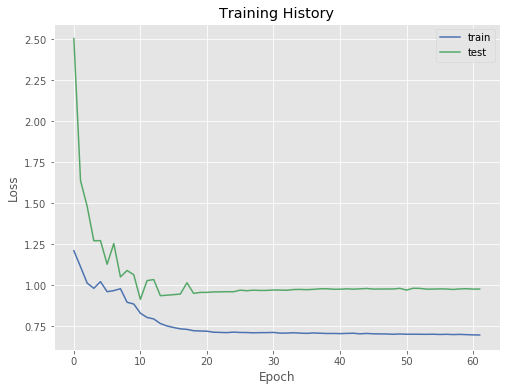

1152/2044 [===============>..............] - ETA: 0s

AUC: 0.5


AUC: 0.68016



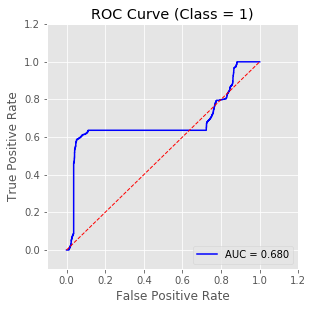

In [28]:
naive_score, fx_auc = do_one_model('CAD', feature_col_names = ['CA_FX'], verbose = 2)

### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


CA_FX, CA_BMP_Ratio

Scaled data shape: (6551, 2)
Reframed data shape: (6192, 361)


CA_FX(t-180),CA_BMP_Ratio(t-180),CA_FX(t-179),CA_BMP_Ratio(t-179),CA_FX(t-178),CA_BMP_Ratio(t-178),CA_FX(t-177),CA_BMP_Ratio(t-177),CA_FX(t-176),CA_BMP_Ratio(t-176),CA_FX(t-175),CA_BMP_Ratio(t-175),CA_FX(t-174),CA_BMP_Ratio(t-174),CA_FX(t-173),CA_BMP_Ratio(t-173),CA_FX(t-172),CA_BMP_Ratio(t-172),CA_FX(t-171),CA_BMP_Ratio(t-171),CA_FX(t-170),CA_BMP_Ratio(t-170),CA_FX(t-169),CA_BMP_Ratio(t-169),CA_FX(t-168),CA_BMP_Ratio(t-168),CA_FX(t-167),CA_BMP_Ratio(t-167),CA_FX(t-166),CA_BMP_Ratio(t-166),CA_FX(t-165),CA_BMP_Ratio(t-165),CA_FX(t-164),CA_BMP_Ratio(t-164),CA_FX(t-163),CA_BMP_Ratio(t-163),CA_FX(t-162),CA_BMP_Ratio(t-162),CA_FX(t-161),CA_BMP_Ratio(t-161),CA_FX(t-160),CA_BMP_Ratio(t-160),CA_FX(t-159),CA_BMP_Ratio(t-159),CA_FX(t-158),CA_BMP_Ratio(t-158),CA_FX(t-157),CA_BMP_Ratio(t-157),CA_FX(t-156),CA_BMP_Ratio(t-156),CA_FX(t-155),CA_BMP_Ratio(t-155),CA_FX(t-154),CA_BMP_Ratio(t-154),CA_FX(t-153),CA_BMP_Ratio(t-153),CA_FX(t-152),CA_BMP_Ratio(t-152),CA_FX(t-151),CA_BMP_Ratio(t-151),CA_FX(t-150),CA_BMP_Ratio(t-150),CA_FX(t-149),CA_BMP_Ratio(t-149),CA_FX(t-148),CA_BMP_Ratio(t-148),CA_FX(t-147),CA_BMP_Ratio(t-147),CA_FX(t-146),CA_BMP_Ratio(t-146),CA_FX(t-145),CA_BMP_Ratio(t-145),CA_FX(t-144),CA_BMP_Ratio(t-144),CA_FX(t-143),CA_BMP_Ratio(t-143),CA_FX(t-142),CA_BMP_Ratio(t-142),CA_FX(t-141),CA_BMP_Ratio(t-141),CA_FX(t-140),CA_BMP_Ratio(t-140),CA_FX(t-139),CA_BMP_Ratio(t-139),CA_FX(t-138),CA_BMP_Ratio(t-138),CA_FX(t-137),CA_BMP_Ratio(t-137),CA_FX(t-136),CA_BMP_Ratio(t-136),CA_FX(t-135),CA_BMP_Ratio(t-135),CA_FX(t-134),CA_BMP_Ratio(t-134),CA_FX(t-133),CA_BMP_Ratio(t-133),CA_FX(t-132),CA_BMP_Ratio(t-132),CA_FX(t-131),CA_BMP_Ratio(t-131),CA_FX(t-130),CA_BMP_Ratio(t-130),CA_FX(t-129),CA_BMP_Ratio(t-129),CA_FX(t-128),CA_BMP_Ratio(t-128),CA_FX(t-127),CA_BMP_Ratio(t-127),CA_FX(t-126),CA_BMP_Ratio(t-126),CA_FX(t-125),CA_BMP_Ratio(t-125),CA_FX(t-124),CA_BMP_Ratio(t-124),CA_FX(t-123),CA_BMP_Ratio(t-123),CA_FX(t-122),CA_BMP_Ratio(t-122),CA_FX(t-121),CA_BMP_Ratio(t-121),CA_FX(t-120),CA_BMP_Ratio(t-120),CA_FX(t-119),CA_BMP_Ratio(t-119),CA_FX(t-118),CA_BMP_Ratio(t-118),CA_FX(t-117),CA_BMP_Ratio(t-117),CA_FX(t-116),CA_BMP_Ratio(t-116),CA_FX(t-115),CA_BMP_Ratio(t-115),CA_FX(t-114),CA_BMP_Ratio(t-114),CA_FX(t-113),CA_BMP_Ratio(t-113),CA_FX(t-112),CA_BMP_Ratio(t-112),CA_FX(t-111),CA_BMP_Ratio(t-111),CA_FX(t-110),CA_BMP_Ratio(t-110),CA_FX(t-109),CA_BMP_Ratio(t-109),CA_FX(t-108),CA_BMP_Ratio(t-108),CA_FX(t-107),CA_BMP_Ratio(t-107),CA_FX(t-106),CA_BMP_Ratio(t-106),CA_FX(t-105),CA_BMP_Ratio(t-105),CA_FX(t-104),CA_BMP_Ratio(t-104),CA_FX(t-103),CA_BMP_Ratio(t-103),CA_FX(t-102),CA_BMP_Ratio(t-102),CA_FX(t-101),CA_BMP_Ratio(t-101),CA_FX(t-100),CA_BMP_Ratio(t-100),CA_FX(t-99),CA_BMP_Ratio(t-99),CA_FX(t-98),CA_BMP_Ratio(t-98),CA_FX(t-97),CA_BMP_Ratio(t-97),CA_FX(t-96),CA_BMP_Ratio(t-96),CA_FX(t-95),CA_BMP_Ratio(t-95),CA_FX(t-94),CA_BMP_Ratio(t-94),CA_FX(t-93),CA_BMP_Ratio(t-93),CA_FX(t-92),CA_BMP_Ratio(t-92),CA_FX(t-91),CA_BMP_Ratio(t-91),CA_FX(t-90),CA_BMP_Ratio(t-90),CA_FX(t-89),CA_BMP_Ratio(t-89),CA_FX(t-88),CA_BMP_Ratio(t-88),CA_FX(t-87),CA_BMP_Ratio(t-87),CA_FX(t-86),CA_BMP_Ratio(t-86),CA_FX(t-85),CA_BMP_Ratio(t-85),CA_FX(t-84),CA_BMP_Ratio(t-84),CA_FX(t-83),CA_BMP_Ratio(t-83),CA_FX(t-82),CA_BMP_Ratio(t-82),CA_FX(t-81),CA_BMP_Ratio(t-81),CA_FX(t-80),CA_BMP_Ratio(t-80),CA_FX(t-79),CA_BMP_Ratio(t-79),CA_FX(t-78),CA_BMP_Ratio(t-78),CA_FX(t-77),CA_BMP_Ratio(t-77),CA_FX(t-76),CA_BMP_Ratio(t-76),CA_FX(t-75),CA_BMP_Ratio(t-75),CA_FX(t-74),CA_BMP_Ratio(t-74),CA_FX(t-73),CA_BMP_Ratio(t-73),CA_FX(t-72),CA_BMP_Ratio(t-72),CA_FX(t-71),CA_BMP_Ratio(t-71),CA_FX(t-70),CA_BMP_Ratio(t-70),CA_FX(t-69),CA_BMP_Ratio(t-69),CA_FX(t-68),CA_BMP_Ratio(t-68),CA_FX(t-67),CA_BMP_Ratio(t-67),CA_FX(t-66),CA_BMP_Ratio(t-66),CA_FX(t-65),CA_BMP_Ratio(t-65),CA_FX(t-64),CA_BMP_Ratio(t-64),CA_FX(t-63),CA_BMP_Ratio(t-63),CA_FX(t-62),CA_BMP_Ratio(t-62),CA_FX(t-61),CA_BMP_Ratio(t-61),CA_FX(t-60),CA_BMP_Ratio(t-60),CA_FX(t-59),CA_BMP_Ratio(t-59),CA_FX(t-58),CA_BMP_Ratio(t-58),CA_FX(t-57),CA_BMP_Ratio(

(4148, 1, 360) (4148,) (2044, 1, 360) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
Epoch 00000: val_loss improved from inf to 1.30310, saving model to ./best_model.hdf5
1s - loss: 1.1311 - val_loss: 1.3031
Epoch 2/200
Epoch 00001: val_loss did not improve
1s - loss: 1.0175 - val_loss: 1.6764
Epoch 3/200
Epoch 00002: val_loss did not improve
1s - loss: 1.0471 - val_loss: 1.5417
Epoch 4/200
Epoch 00003: val_loss did not improve
1s - loss: 1.0528 - val_loss: 1.5115
Epoch 5/200
Epoch 00004: val_loss did not improve
1s - loss: 1.0278 - val_loss: 2.1205
Epoch 6/200
Epoch 00005: val_loss did not improve
1s - loss: 1.0580 - val_loss: 1.9461
Epoch 7/200
Epoch 00006: val_loss did not improve
1s - loss: 0.9783 - val_loss: 1.5497
Epoch 8/200
Epoch 00007: val_loss improved from 1.30310 to 1.10538, saving model to ./best_model.hdf5
1s - loss: 0.8813 - val_loss: 1.1054
Epoch 9/200
Epoch 00008: val_loss did not improve
1s - loss: 0.9072 - val_loss: 1.3952
Epoch 10/200
Epoch 00009: val_loss did not improve
1s - loss: 0.9482 

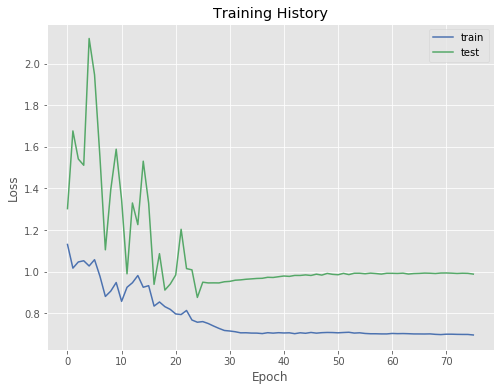

1024/2044 [==============>...............] - ETA: 0s 

AUC: 0.5


AUC: 0.70902



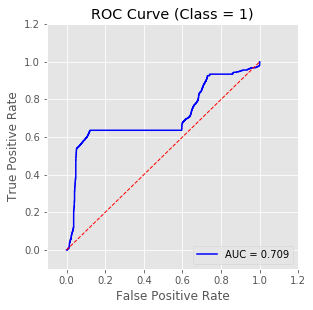

In [29]:
naive_score, fx_features_auc = do_one_model('CAD', feature_col_names =  ['CA_FX', 'CA_BMP_Ratio'])

### All features

In [30]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('CA_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('CAD', feature_col_names = ['CA_FX'] + cols, do_pca = True)

In [31]:
all_results = accum_results(all_results, 'CAD', naive_score, fx_auc, fx_features_auc, fx_all_auc)

## Japan

### FX rates only

Time period: 2000-01-03 - 2017-12-09


JP_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6192, 181)


JP_FX(t-180),JP_FX(t-179),JP_FX(t-178),JP_FX(t-177),JP_FX(t-176),JP_FX(t-175),JP_FX(t-174),JP_FX(t-173),JP_FX(t-172),JP_FX(t-171),JP_FX(t-170),JP_FX(t-169),JP_FX(t-168),JP_FX(t-167),JP_FX(t-166),JP_FX(t-165),JP_FX(t-164),JP_FX(t-163),JP_FX(t-162),JP_FX(t-161),JP_FX(t-160),JP_FX(t-159),JP_FX(t-158),JP_FX(t-157),JP_FX(t-156),JP_FX(t-155),JP_FX(t-154),JP_FX(t-153),JP_FX(t-152),JP_FX(t-151),JP_FX(t-150),JP_FX(t-149),JP_FX(t-148),JP_FX(t-147),JP_FX(t-146),JP_FX(t-145),JP_FX(t-144),JP_FX(t-143),JP_FX(t-142),JP_FX(t-141),JP_FX(t-140),JP_FX(t-139),JP_FX(t-138),JP_FX(t-137),JP_FX(t-136),JP_FX(t-135),JP_FX(t-134),JP_FX(t-133),JP_FX(t-132),JP_FX(t-131),JP_FX(t-130),JP_FX(t-129),JP_FX(t-128),JP_FX(t-127),JP_FX(t-126),JP_FX(t-125),JP_FX(t-124),JP_FX(t-123),JP_FX(t-122),JP_FX(t-121),JP_FX(t-120),JP_FX(t-119),JP_FX(t-118),JP_FX(t-117),JP_FX(t-116),JP_FX(t-115),JP_FX(t-114),JP_FX(t-113),JP_FX(t-112),JP_FX(t-111),JP_FX(t-110),JP_FX(t-109),JP_FX(t-108),JP_FX(t-107),JP_FX(t-106),JP_FX(t-105),JP_FX(t-104),JP_FX(t-103),JP_FX(t-102),JP_FX(t-101),JP_FX(t-100),JP_FX(t-99),JP_FX(t-98),JP_FX(t-97),JP_FX(t-96),JP_FX(t-95),JP_FX(t-94),JP_FX(t-93),JP_FX(t-92),JP_FX(t-91),JP_FX(t-90),JP_FX(t-89),JP_FX(t-88),JP_FX(t-87),JP_FX(t-86),JP_FX(t-85),JP_FX(t-84),JP_FX(t-83),JP_FX(t-82),JP_FX(t-81),JP_FX(t-80),JP_FX(t-79),JP_FX(t-78),JP_FX(t-77),JP_FX(t-76),JP_FX(t-75),JP_FX(t-74),JP_FX(t-73),JP_FX(t-72),JP_FX(t-71),JP_FX(t-70),JP_FX(t-69),JP_FX(t-68),JP_FX(t-67),JP_FX(t-66),JP_FX(t-65),JP_FX(t-64),JP_FX(t-63),JP_FX(t-62),JP_FX(t-61),JP_FX(t-60),JP_FX(t-59),JP_FX(t-58),JP_FX(t-57),JP_FX(t-56),JP_FX(t-55),JP_FX(t-54),JP_FX(t-53),JP_FX(t-52),JP_FX(t-51),JP_FX(t-50),JP_FX(t-49),JP_FX(t-48),JP_FX(t-47),JP_FX(t-46),JP_FX(t-45),JP_FX(t-44),JP_FX(t-43),JP_FX(t-42),JP_FX(t-41),JP_FX(t-40),JP_FX(t-39),JP_FX(t-38),JP_FX(t-37),JP_FX(t-36),JP_FX(t-35),JP_FX(t-34),JP_FX(t-33),JP_FX(t-32),JP_FX(t-31),JP_FX(t-30),JP_FX(t-29),JP_FX(t-28),JP_FX(t-27),JP_FX(t-26),JP_FX(t-25),JP_FX(t-24),JP_FX(t-23),JP_FX(t-22),JP_FX(t-21),JP_FX(t-20),JP_FX(t-19),JP_FX(t-18),JP_FX(t-17),JP_FX(t-16),JP_FX(t-15),JP_FX(t-14),JP_FX(t-13),JP_FX(t-12),JP_FX(t-11),JP_FX(t-10),JP_FX(t-9),JP_FX(t-8),JP_FX(t-7),JP_FX(t-6),JP_FX(t-5),JP_FX(t-4),JP_FX(t-3),JP_FX(t-2),JP_FX(t-1),Is_Up
0.416969,0.394057,0.383072,0.360591,0.360903,0.360330,0.359758,0.359186,0.346653,0.351736,0.346653,0.350193,0.351144,0.352097,0.353050,0.355918,0.357473,0.356540,0.364191,0.361268,0.358355,0.355453,0.350038,0.350347,0.364975,0.330539,0.329636,0.328734,0.327834,0.322749,0.311940,0.319031,0.324690,0.318685,0.312725,0.306809,0.294629,0.301566,0.306956,0.303310,0.304961,0.306615,0.308272,0.306809,0.297657,0.284905,0.276283,0.275908,0.275533,0.275159,0.274037,0.273056,0.275299,0.274878,0.283390,0.291995,0.300696,0.290467,0.331292,0.327234,0.320814,0.321111,0.321409,0.321706,0.344966,0.334462,0.341144,0.343894,0.348755,0.353644,0.358563,0.365918,0.354522,0.353747,0.346500,0.344456,0.342416,0.340382,0.334159,0.336279,0.326036,0.329035,0.329636,0.330238,0.330840,0.349576,0.354212,0.355297,0.399932,0.388601,0.377421,0.366390,0.358407,0.363563,0.367019,0.358407,0.353025,0.347678,0.342365,0.333555,0.350193,0.351736,0.361685,0.366547,0.371438,0.376359,0.370015,0.364505,0.356540,0.349884,0.351015,0.352148,0.353283,0.352509,0.340992,0.342518,0.318141,0.313658,0.309200,0.304766,0.308565,0.301131,0.315330,0.310031,0.307589,0.305155,0.302728,0.294341,0.298379,0.310912,0.306956,0.303359,0.299778,0.296213,0.292330,0.295493,0.307540,0.334462,0.333807,0.333152,0.332498,0.337037,0.324092,0.325587,0.330087,0.331945,0.333807,0.335673,0.341297,0.321706,0.306956,0.315626,0.319130,0.322650,0.326185,0.353592,0.355763,0.350193,0.336127,0.336784,0.337442,0.338100,0.335976,0.334462,0.340078,0.344660,0.347114,0.349576,0.352045,0.357006,0.355763,0.373022,0.370015,0.364400,0.358822,0.353283,0.355297,0.355608,0.362154,0.345886,0
0.394057,0.383072,0.360591,0.360903,0.360330,0.359758,0.359186,0.346653,0.351736,0.346653,0.350193,0.351144,0.352097,0.353050,0.355918,0.357

(4148, 1, 180) (4148,) (2044, 1, 180) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
Epoch 00000: val_loss improved from inf to 1.71259, saving model to ./best_model.hdf5
1s - loss: 0.8383 - val_loss: 1.7126
Epoch 2/200
Epoch 00001: val_loss improved from 1.71259 to 1.51723, saving model to ./best_model.hdf5
1s - loss: 0.7174 - val_loss: 1.5172
Epoch 3/200
Epoch 00002: val_loss improved from 1.51723 to 1.46727, saving model to ./best_model.hdf5
1s - loss: 0.7148 - val_loss: 1.4673
Epoch 4/200
Epoch 00003: val_loss did not improve
1s - loss: 0.7087 - val_loss: 1.4742
Epoch 5/200
Epoch 00004: val_loss did not improve
1s - loss: 0.7301 - val_loss: 1.7954
Epoch 6/200
Epoch 00005: val_loss did not improve
1s - loss: 0.7866 - val_loss: 1.7787
Epoch 7/200
Epoch 00006: val_loss did not improve
1s - loss: 0.8581 - val_loss: 1.6827
Epoch 8/200
Epoch 00007: val_loss did not improve
1s - loss: 0.8721 - val_loss: 1.8369
Epoch 9/200
Epoch 00008: val_loss did not improve
1s - loss: 0.8616 - val_loss: 1.6094
Epoch 10/200
Epoc

Epoch 00075: val_loss did not improve
1s - loss: 0.7138 - val_loss: 1.1778
Epoch 77/200
Epoch 00076: val_loss did not improve
1s - loss: 0.7124 - val_loss: 1.1892
Epoch 78/200
Epoch 00077: val_loss did not improve
1s - loss: 0.7129 - val_loss: 1.1933
Epoch 79/200
Epoch 00078: val_loss did not improve
1s - loss: 0.7156 - val_loss: 1.1848
Epoch 80/200
Epoch 00079: val_loss did not improve
1s - loss: 0.7126 - val_loss: 1.1911
Epoch 81/200
Epoch 00080: val_loss did not improve
1s - loss: 0.7148 - val_loss: 1.1764
Epoch 82/200
Epoch 00081: val_loss did not improve
1s - loss: 0.7129 - val_loss: 1.1863
Epoch 83/200
Epoch 00082: val_loss did not improve
1s - loss: 0.7116 - val_loss: 1.1848
Epoch 84/200
Epoch 00083: val_loss did not improve
1s - loss: 0.7102 - val_loss: 1.1910
Epoch 85/200
Epoch 00084: val_loss did not improve
1s - loss: 0.7119 - val_loss: 1.1805
Epoch 86/200
Epoch 00085: val_loss did not improve
1s - loss: 0.7114 - val_loss: 1.1705
Epoch 87/200
Epoch 00086: val_loss did not im

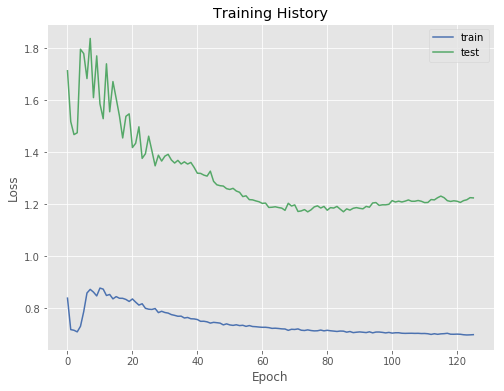

1120/2044 [===============>..............] - ETA: 0s 

AUC: 0.5


AUC: 0.19403



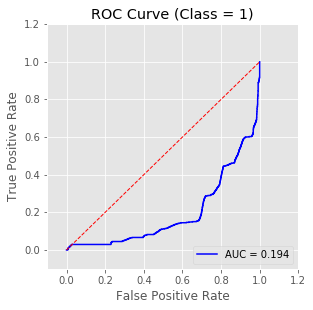

In [32]:
naive_score, fx_auc = do_one_model('JPY', feature_col_names = ['JP_FX'], verbose = 2)

### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


JP_FX, JP_BMP_Ratio

Scaled data shape: (6551, 2)
Reframed data shape: (6192, 361)


JP_FX(t-180),JP_BMP_Ratio(t-180),JP_FX(t-179),JP_BMP_Ratio(t-179),JP_FX(t-178),JP_BMP_Ratio(t-178),JP_FX(t-177),JP_BMP_Ratio(t-177),JP_FX(t-176),JP_BMP_Ratio(t-176),JP_FX(t-175),JP_BMP_Ratio(t-175),JP_FX(t-174),JP_BMP_Ratio(t-174),JP_FX(t-173),JP_BMP_Ratio(t-173),JP_FX(t-172),JP_BMP_Ratio(t-172),JP_FX(t-171),JP_BMP_Ratio(t-171),JP_FX(t-170),JP_BMP_Ratio(t-170),JP_FX(t-169),JP_BMP_Ratio(t-169),JP_FX(t-168),JP_BMP_Ratio(t-168),JP_FX(t-167),JP_BMP_Ratio(t-167),JP_FX(t-166),JP_BMP_Ratio(t-166),JP_FX(t-165),JP_BMP_Ratio(t-165),JP_FX(t-164),JP_BMP_Ratio(t-164),JP_FX(t-163),JP_BMP_Ratio(t-163),JP_FX(t-162),JP_BMP_Ratio(t-162),JP_FX(t-161),JP_BMP_Ratio(t-161),JP_FX(t-160),JP_BMP_Ratio(t-160),JP_FX(t-159),JP_BMP_Ratio(t-159),JP_FX(t-158),JP_BMP_Ratio(t-158),JP_FX(t-157),JP_BMP_Ratio(t-157),JP_FX(t-156),JP_BMP_Ratio(t-156),JP_FX(t-155),JP_BMP_Ratio(t-155),JP_FX(t-154),JP_BMP_Ratio(t-154),JP_FX(t-153),JP_BMP_Ratio(t-153),JP_FX(t-152),JP_BMP_Ratio(t-152),JP_FX(t-151),JP_BMP_Ratio(t-151),JP_FX(t-150),JP_BMP_Ratio(t-150),JP_FX(t-149),JP_BMP_Ratio(t-149),JP_FX(t-148),JP_BMP_Ratio(t-148),JP_FX(t-147),JP_BMP_Ratio(t-147),JP_FX(t-146),JP_BMP_Ratio(t-146),JP_FX(t-145),JP_BMP_Ratio(t-145),JP_FX(t-144),JP_BMP_Ratio(t-144),JP_FX(t-143),JP_BMP_Ratio(t-143),JP_FX(t-142),JP_BMP_Ratio(t-142),JP_FX(t-141),JP_BMP_Ratio(t-141),JP_FX(t-140),JP_BMP_Ratio(t-140),JP_FX(t-139),JP_BMP_Ratio(t-139),JP_FX(t-138),JP_BMP_Ratio(t-138),JP_FX(t-137),JP_BMP_Ratio(t-137),JP_FX(t-136),JP_BMP_Ratio(t-136),JP_FX(t-135),JP_BMP_Ratio(t-135),JP_FX(t-134),JP_BMP_Ratio(t-134),JP_FX(t-133),JP_BMP_Ratio(t-133),JP_FX(t-132),JP_BMP_Ratio(t-132),JP_FX(t-131),JP_BMP_Ratio(t-131),JP_FX(t-130),JP_BMP_Ratio(t-130),JP_FX(t-129),JP_BMP_Ratio(t-129),JP_FX(t-128),JP_BMP_Ratio(t-128),JP_FX(t-127),JP_BMP_Ratio(t-127),JP_FX(t-126),JP_BMP_Ratio(t-126),JP_FX(t-125),JP_BMP_Ratio(t-125),JP_FX(t-124),JP_BMP_Ratio(t-124),JP_FX(t-123),JP_BMP_Ratio(t-123),JP_FX(t-122),JP_BMP_Ratio(t-122),JP_FX(t-121),JP_BMP_Ratio(t-121),JP_FX(t-120),JP_BMP_Ratio(t-120),JP_FX(t-119),JP_BMP_Ratio(t-119),JP_FX(t-118),JP_BMP_Ratio(t-118),JP_FX(t-117),JP_BMP_Ratio(t-117),JP_FX(t-116),JP_BMP_Ratio(t-116),JP_FX(t-115),JP_BMP_Ratio(t-115),JP_FX(t-114),JP_BMP_Ratio(t-114),JP_FX(t-113),JP_BMP_Ratio(t-113),JP_FX(t-112),JP_BMP_Ratio(t-112),JP_FX(t-111),JP_BMP_Ratio(t-111),JP_FX(t-110),JP_BMP_Ratio(t-110),JP_FX(t-109),JP_BMP_Ratio(t-109),JP_FX(t-108),JP_BMP_Ratio(t-108),JP_FX(t-107),JP_BMP_Ratio(t-107),JP_FX(t-106),JP_BMP_Ratio(t-106),JP_FX(t-105),JP_BMP_Ratio(t-105),JP_FX(t-104),JP_BMP_Ratio(t-104),JP_FX(t-103),JP_BMP_Ratio(t-103),JP_FX(t-102),JP_BMP_Ratio(t-102),JP_FX(t-101),JP_BMP_Ratio(t-101),JP_FX(t-100),JP_BMP_Ratio(t-100),JP_FX(t-99),JP_BMP_Ratio(t-99),JP_FX(t-98),JP_BMP_Ratio(t-98),JP_FX(t-97),JP_BMP_Ratio(t-97),JP_FX(t-96),JP_BMP_Ratio(t-96),JP_FX(t-95),JP_BMP_Ratio(t-95),JP_FX(t-94),JP_BMP_Ratio(t-94),JP_FX(t-93),JP_BMP_Ratio(t-93),JP_FX(t-92),JP_BMP_Ratio(t-92),JP_FX(t-91),JP_BMP_Ratio(t-91),JP_FX(t-90),JP_BMP_Ratio(t-90),JP_FX(t-89),JP_BMP_Ratio(t-89),JP_FX(t-88),JP_BMP_Ratio(t-88),JP_FX(t-87),JP_BMP_Ratio(t-87),JP_FX(t-86),JP_BMP_Ratio(t-86),JP_FX(t-85),JP_BMP_Ratio(t-85),JP_FX(t-84),JP_BMP_Ratio(t-84),JP_FX(t-83),JP_BMP_Ratio(t-83),JP_FX(t-82),JP_BMP_Ratio(t-82),JP_FX(t-81),JP_BMP_Ratio(t-81),JP_FX(t-80),JP_BMP_Ratio(t-80),JP_FX(t-79),JP_BMP_Ratio(t-79),JP_FX(t-78),JP_BMP_Ratio(t-78),JP_FX(t-77),JP_BMP_Ratio(t-77),JP_FX(t-76),JP_BMP_Ratio(t-76),JP_FX(t-75),JP_BMP_Ratio(t-75),JP_FX(t-74),JP_BMP_Ratio(t-74),JP_FX(t-73),JP_BMP_Ratio(t-73),JP_FX(t-72),JP_BMP_Ratio(t-72),JP_FX(t-71),JP_BMP_Ratio(t-71),JP_FX(t-70),JP_BMP_Ratio(t-70),JP_FX(t-69),JP_BMP_Ratio(t-69),JP_FX(t-68),JP_BMP_Ratio(t-68),JP_FX(t-67),JP_BMP_Ratio(t-67),JP_FX(t-66),JP_BMP_Ratio(t-66),JP_FX(t-65),JP_BMP_Ratio(t-65),JP_FX(t-64),JP_BMP_Ratio(t-64),JP_FX(t-63),JP_BMP_Ratio(t-63),JP_FX(t-62),JP_BMP_Ratio(t-62),JP_FX(t-61),JP_BMP_Ratio(t-61),JP_FX(t-60),JP_BMP_Ratio(t-60),JP_FX(t-59),JP_BMP_Ratio(t-59),JP_FX(t-58),JP_BMP_Ratio(t-58),JP_FX(t-57),JP_BMP_Ratio(

(4148, 1, 360) (4148,) (2044, 1, 360) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
Epoch 00000: val_loss improved from inf to 1.14305, saving model to ./best_model.hdf5
1s - loss: 0.9968 - val_loss: 1.1431
Epoch 2/200
Epoch 00001: val_loss did not improve
1s - loss: 0.7731 - val_loss: 1.9648
Epoch 3/200
Epoch 00002: val_loss did not improve
1s - loss: 1.0787 - val_loss: 2.0446
Epoch 4/200
Epoch 00003: val_loss did not improve
1s - loss: 1.1344 - val_loss: 1.6706
Epoch 5/200
Epoch 00004: val_loss did not improve
1s - loss: 0.8695 - val_loss: 1.8871
Epoch 6/200
Epoch 00005: val_loss did not improve
1s - loss: 0.8751 - val_loss: 1.6351
Epoch 7/200
Epoch 00006: val_loss did not improve
1s - loss: 0.7853 - val_loss: 1.6134
Epoch 8/200
Epoch 00007: val_loss did not improve
1s - loss: 0.8604 - val_loss: 1.5564
Epoch 9/200
Epoch 00008: val_loss did not improve
1s - loss: 0.7693 - val_loss: 1.6187
Epoch 10/200
Epoch 00009: val_loss did not improve
1s - loss: 0.8380 - val_loss: 2.1720
Epoch 11/200
Epoch 00010: val_los

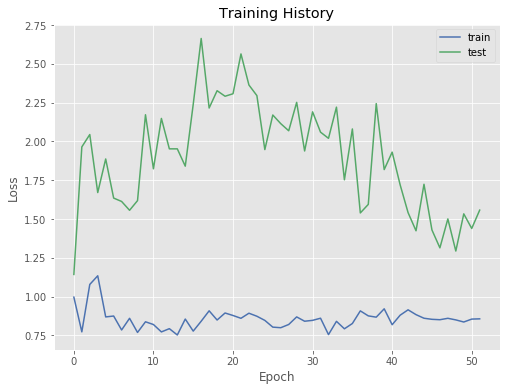

2044/2044 [==============================] - 0s     


AUC: 0.5


AUC: 0.49896



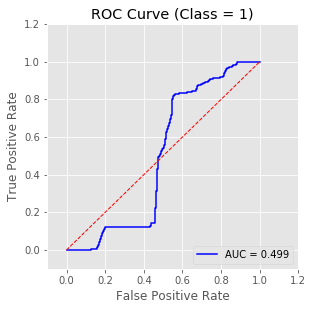

In [33]:
naive_score, fx_features_auc = do_one_model('JPY', feature_col_names = ['JP_FX', 'JP_BMP_Ratio'])

### All features

In [34]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('JP_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('JPY', feature_col_names = ['JP_FX'] + cols, do_pca = True)

In [35]:
all_results = accum_results(all_results, 'JPY', naive_score, fx_auc, fx_features_auc, fx_all_auc)

## Switzerland

### FX rates only

Time period: 2000-01-03 - 2017-12-09


CH_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6192, 181)


CH_FX(t-180),CH_FX(t-179),CH_FX(t-178),CH_FX(t-177),CH_FX(t-176),CH_FX(t-175),CH_FX(t-174),CH_FX(t-173),CH_FX(t-172),CH_FX(t-171),CH_FX(t-170),CH_FX(t-169),CH_FX(t-168),CH_FX(t-167),CH_FX(t-166),CH_FX(t-165),CH_FX(t-164),CH_FX(t-163),CH_FX(t-162),CH_FX(t-161),CH_FX(t-160),CH_FX(t-159),CH_FX(t-158),CH_FX(t-157),CH_FX(t-156),CH_FX(t-155),CH_FX(t-154),CH_FX(t-153),CH_FX(t-152),CH_FX(t-151),CH_FX(t-150),CH_FX(t-149),CH_FX(t-148),CH_FX(t-147),CH_FX(t-146),CH_FX(t-145),CH_FX(t-144),CH_FX(t-143),CH_FX(t-142),CH_FX(t-141),CH_FX(t-140),CH_FX(t-139),CH_FX(t-138),CH_FX(t-137),CH_FX(t-136),CH_FX(t-135),CH_FX(t-134),CH_FX(t-133),CH_FX(t-132),CH_FX(t-131),CH_FX(t-130),CH_FX(t-129),CH_FX(t-128),CH_FX(t-127),CH_FX(t-126),CH_FX(t-125),CH_FX(t-124),CH_FX(t-123),CH_FX(t-122),CH_FX(t-121),CH_FX(t-120),CH_FX(t-119),CH_FX(t-118),CH_FX(t-117),CH_FX(t-116),CH_FX(t-115),CH_FX(t-114),CH_FX(t-113),CH_FX(t-112),CH_FX(t-111),CH_FX(t-110),CH_FX(t-109),CH_FX(t-108),CH_FX(t-107),CH_FX(t-106),CH_FX(t-105),CH_FX(t-104),CH_FX(t-103),CH_FX(t-102),CH_FX(t-101),CH_FX(t-100),CH_FX(t-99),CH_FX(t-98),CH_FX(t-97),CH_FX(t-96),CH_FX(t-95),CH_FX(t-94),CH_FX(t-93),CH_FX(t-92),CH_FX(t-91),CH_FX(t-90),CH_FX(t-89),CH_FX(t-88),CH_FX(t-87),CH_FX(t-86),CH_FX(t-85),CH_FX(t-84),CH_FX(t-83),CH_FX(t-82),CH_FX(t-81),CH_FX(t-80),CH_FX(t-79),CH_FX(t-78),CH_FX(t-77),CH_FX(t-76),CH_FX(t-75),CH_FX(t-74),CH_FX(t-73),CH_FX(t-72),CH_FX(t-71),CH_FX(t-70),CH_FX(t-69),CH_FX(t-68),CH_FX(t-67),CH_FX(t-66),CH_FX(t-65),CH_FX(t-64),CH_FX(t-63),CH_FX(t-62),CH_FX(t-61),CH_FX(t-60),CH_FX(t-59),CH_FX(t-58),CH_FX(t-57),CH_FX(t-56),CH_FX(t-55),CH_FX(t-54),CH_FX(t-53),CH_FX(t-52),CH_FX(t-51),CH_FX(t-50),CH_FX(t-49),CH_FX(t-48),CH_FX(t-47),CH_FX(t-46),CH_FX(t-45),CH_FX(t-44),CH_FX(t-43),CH_FX(t-42),CH_FX(t-41),CH_FX(t-40),CH_FX(t-39),CH_FX(t-38),CH_FX(t-37),CH_FX(t-36),CH_FX(t-35),CH_FX(t-34),CH_FX(t-33),CH_FX(t-32),CH_FX(t-31),CH_FX(t-30),CH_FX(t-29),CH_FX(t-28),CH_FX(t-27),CH_FX(t-26),CH_FX(t-25),CH_FX(t-24),CH_FX(t-23),CH_FX(t-22),CH_FX(t-21),CH_FX(t-20),CH_FX(t-19),CH_FX(t-18),CH_FX(t-17),CH_FX(t-16),CH_FX(t-15),CH_FX(t-14),CH_FX(t-13),CH_FX(t-12),CH_FX(t-11),CH_FX(t-10),CH_FX(t-9),CH_FX(t-8),CH_FX(t-7),CH_FX(t-6),CH_FX(t-5),CH_FX(t-4),CH_FX(t-3),CH_FX(t-2),CH_FX(t-1),Is_Up
0.777068,0.754884,0.751324,0.752602,0.760179,0.762644,0.765109,0.767573,0.758536,0.763557,0.767847,0.789575,0.789529,0.789483,0.789438,0.789301,0.791400,0.786836,0.792131,0.795691,0.799251,0.802812,0.802355,0.803907,0.823535,0.838872,0.839176,0.839480,0.839785,0.843893,0.840424,0.817875,0.837502,0.836163,0.834824,0.833485,0.822074,0.815775,0.820157,0.822439,0.826395,0.830351,0.834307,0.824722,0.822165,0.819609,0.820340,0.815790,0.811241,0.806692,0.793044,0.802081,0.812854,0.837959,0.842219,0.846479,0.850739,0.855304,0.846449,0.859777,0.859595,0.860751,0.861907,0.863064,0.868541,0.864890,0.848914,0.854939,0.856186,0.857434,0.858682,0.859869,0.851013,0.848731,0.851196,0.850739,0.850283,0.849827,0.850739,0.863064,0.842249,0.824995,0.829104,0.833212,0.837320,0.844897,0.860781,0.849827,0.852109,0.850800,0.849492,0.848183,0.840241,0.824722,0.830199,0.829560,0.831142,0.832725,0.834307,0.832481,0.839328,0.842067,0.831842,0.832816,0.833790,0.834764,0.849644,0.863520,0.865072,0.863977,0.862516,0.861055,0.859595,0.884517,0.893646,0.914187,0.908709,0.905210,0.901710,0.898211,0.902775,0.919573,0.918112,0.915373,0.914826,0.914278,0.913730,0.905879,0.899580,0.908892,0.894103,0.892368,0.890634,0.888899,0.899763,0.922220,0.920303,0.917564,0.912635,0.907705,0.902775,0.912817,0.904875,0.905058,0.870184,0.871052,0.871919,0.872786,0.875388,0.875205,0.874749,0.856673,0.855152,0.853630,0.852109,0.833851,0.827917,0.832025,0.835037,0.832390,0.829743,0.827095,0.817875,0.823626,0.829834,0.810845,0.812428,0.814010,0.815592,0.820157,0.830199,0.836133,0.846175,0.844501,0.842828,0.841154,0.829195,0.832938,0.828830,0.823535,1
0.754884,0.751324,0.752602,0.760179,0.762644,0.765109,0.767573,0.758536,0.763557,0.767847,0.789575,0.789529,0.789483,0.789438,0.789301,0.791

(4148, 1, 180) (4148,) (2044, 1, 180) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
Epoch 00000: val_loss improved from inf to 1.43231, saving model to ./best_model.hdf5
1s - loss: 1.0435 - val_loss: 1.4323
Epoch 2/200
Epoch 00001: val_loss did not improve
1s - loss: 1.0639 - val_loss: 1.7623
Epoch 3/200
Epoch 00002: val_loss did not improve
1s - loss: 0.9535 - val_loss: 1.4641
Epoch 4/200
Epoch 00003: val_loss improved from 1.43231 to 1.24134, saving model to ./best_model.hdf5
1s - loss: 0.8248 - val_loss: 1.2413
Epoch 5/200
Epoch 00004: val_loss improved from 1.24134 to 1.14932, saving model to ./best_model.hdf5
1s - loss: 0.7583 - val_loss: 1.1493
Epoch 6/200
Epoch 00005: val_loss improved from 1.14932 to 1.13311, saving model to ./best_model.hdf5
1s - loss: 0.7280 - val_loss: 1.1331
Epoch 7/200
Epoch 00006: val_loss improved from 1.13311 to 1.11755, saving model to ./best_model.hdf5
1s - loss: 0.6907 - val_loss: 1.1175
Epoch 8/200
Epoch 00007: val_loss improved from 1.11755 to 1.11747, saving model to ./b

Epoch 00072: val_loss did not improve
1s - loss: 0.5951 - val_loss: 1.0378
Epoch 74/200
Epoch 00073: val_loss did not improve
1s - loss: 0.5945 - val_loss: 1.0343
Epoch 75/200
Epoch 00074: val_loss did not improve
1s - loss: 0.5969 - val_loss: 1.0337
Epoch 76/200
Epoch 00075: val_loss improved from 1.03344 to 1.03269, saving model to ./best_model.hdf5
1s - loss: 0.5955 - val_loss: 1.0327
Epoch 77/200
Epoch 00076: val_loss improved from 1.03269 to 1.03237, saving model to ./best_model.hdf5
1s - loss: 0.5961 - val_loss: 1.0324
Epoch 78/200
Epoch 00077: val_loss did not improve
1s - loss: 0.5963 - val_loss: 1.0330
Epoch 79/200
Epoch 00078: val_loss improved from 1.03237 to 1.02915, saving model to ./best_model.hdf5
1s - loss: 0.5940 - val_loss: 1.0292
Epoch 80/200
Epoch 00079: val_loss did not improve
1s - loss: 0.5925 - val_loss: 1.0337
Epoch 81/200
Epoch 00080: val_loss improved from 1.02915 to 1.02856, saving model to ./best_model.hdf5
1s - loss: 0.5906 - val_loss: 1.0286
Epoch 82/200


Epoch 00149: val_loss did not improve
1s - loss: 0.5667 - val_loss: 1.0001
Epoch 151/200
Epoch 00150: val_loss improved from 0.99975 to 0.99811, saving model to ./best_model.hdf5
1s - loss: 0.5674 - val_loss: 0.9981
Epoch 152/200
Epoch 00151: val_loss did not improve
1s - loss: 0.5673 - val_loss: 0.9981
Epoch 153/200
Epoch 00152: val_loss did not improve
1s - loss: 0.5679 - val_loss: 1.0014
Epoch 154/200
Epoch 00153: val_loss did not improve
1s - loss: 0.5673 - val_loss: 0.9997
Epoch 155/200
Epoch 00154: val_loss improved from 0.99811 to 0.99680, saving model to ./best_model.hdf5
1s - loss: 0.5657 - val_loss: 0.9968
Epoch 156/200
Epoch 00155: val_loss did not improve
1s - loss: 0.5667 - val_loss: 1.0017
Epoch 157/200
Epoch 00156: val_loss did not improve
1s - loss: 0.5684 - val_loss: 0.9987
Epoch 158/200
Epoch 00157: val_loss did not improve
1s - loss: 0.5657 - val_loss: 0.9976
Epoch 159/200
Epoch 00158: val_loss did not improve
1s - loss: 0.5653 - val_loss: 0.9983
Epoch 160/200
Epoch 

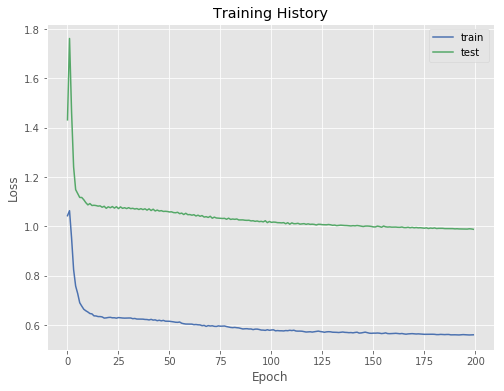

1120/2044 [===============>..............] - ETA: 0s 

AUC: 0.5


AUC: 0.57046



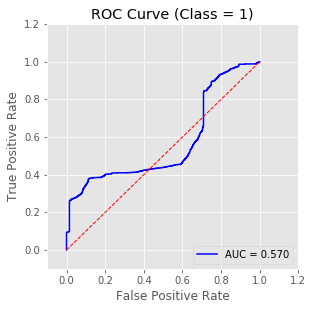

In [36]:
naive_score, fx_auc = do_one_model('CHF', feature_col_names = ['CH_FX'], verbose = 2)

### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


CH_FX, CH_BMP_Ratio

Scaled data shape: (6551, 2)
Reframed data shape: (6192, 361)


CH_FX(t-180),CH_BMP_Ratio(t-180),CH_FX(t-179),CH_BMP_Ratio(t-179),CH_FX(t-178),CH_BMP_Ratio(t-178),CH_FX(t-177),CH_BMP_Ratio(t-177),CH_FX(t-176),CH_BMP_Ratio(t-176),CH_FX(t-175),CH_BMP_Ratio(t-175),CH_FX(t-174),CH_BMP_Ratio(t-174),CH_FX(t-173),CH_BMP_Ratio(t-173),CH_FX(t-172),CH_BMP_Ratio(t-172),CH_FX(t-171),CH_BMP_Ratio(t-171),CH_FX(t-170),CH_BMP_Ratio(t-170),CH_FX(t-169),CH_BMP_Ratio(t-169),CH_FX(t-168),CH_BMP_Ratio(t-168),CH_FX(t-167),CH_BMP_Ratio(t-167),CH_FX(t-166),CH_BMP_Ratio(t-166),CH_FX(t-165),CH_BMP_Ratio(t-165),CH_FX(t-164),CH_BMP_Ratio(t-164),CH_FX(t-163),CH_BMP_Ratio(t-163),CH_FX(t-162),CH_BMP_Ratio(t-162),CH_FX(t-161),CH_BMP_Ratio(t-161),CH_FX(t-160),CH_BMP_Ratio(t-160),CH_FX(t-159),CH_BMP_Ratio(t-159),CH_FX(t-158),CH_BMP_Ratio(t-158),CH_FX(t-157),CH_BMP_Ratio(t-157),CH_FX(t-156),CH_BMP_Ratio(t-156),CH_FX(t-155),CH_BMP_Ratio(t-155),CH_FX(t-154),CH_BMP_Ratio(t-154),CH_FX(t-153),CH_BMP_Ratio(t-153),CH_FX(t-152),CH_BMP_Ratio(t-152),CH_FX(t-151),CH_BMP_Ratio(t-151),CH_FX(t-150),CH_BMP_Ratio(t-150),CH_FX(t-149),CH_BMP_Ratio(t-149),CH_FX(t-148),CH_BMP_Ratio(t-148),CH_FX(t-147),CH_BMP_Ratio(t-147),CH_FX(t-146),CH_BMP_Ratio(t-146),CH_FX(t-145),CH_BMP_Ratio(t-145),CH_FX(t-144),CH_BMP_Ratio(t-144),CH_FX(t-143),CH_BMP_Ratio(t-143),CH_FX(t-142),CH_BMP_Ratio(t-142),CH_FX(t-141),CH_BMP_Ratio(t-141),CH_FX(t-140),CH_BMP_Ratio(t-140),CH_FX(t-139),CH_BMP_Ratio(t-139),CH_FX(t-138),CH_BMP_Ratio(t-138),CH_FX(t-137),CH_BMP_Ratio(t-137),CH_FX(t-136),CH_BMP_Ratio(t-136),CH_FX(t-135),CH_BMP_Ratio(t-135),CH_FX(t-134),CH_BMP_Ratio(t-134),CH_FX(t-133),CH_BMP_Ratio(t-133),CH_FX(t-132),CH_BMP_Ratio(t-132),CH_FX(t-131),CH_BMP_Ratio(t-131),CH_FX(t-130),CH_BMP_Ratio(t-130),CH_FX(t-129),CH_BMP_Ratio(t-129),CH_FX(t-128),CH_BMP_Ratio(t-128),CH_FX(t-127),CH_BMP_Ratio(t-127),CH_FX(t-126),CH_BMP_Ratio(t-126),CH_FX(t-125),CH_BMP_Ratio(t-125),CH_FX(t-124),CH_BMP_Ratio(t-124),CH_FX(t-123),CH_BMP_Ratio(t-123),CH_FX(t-122),CH_BMP_Ratio(t-122),CH_FX(t-121),CH_BMP_Ratio(t-121),CH_FX(t-120),CH_BMP_Ratio(t-120),CH_FX(t-119),CH_BMP_Ratio(t-119),CH_FX(t-118),CH_BMP_Ratio(t-118),CH_FX(t-117),CH_BMP_Ratio(t-117),CH_FX(t-116),CH_BMP_Ratio(t-116),CH_FX(t-115),CH_BMP_Ratio(t-115),CH_FX(t-114),CH_BMP_Ratio(t-114),CH_FX(t-113),CH_BMP_Ratio(t-113),CH_FX(t-112),CH_BMP_Ratio(t-112),CH_FX(t-111),CH_BMP_Ratio(t-111),CH_FX(t-110),CH_BMP_Ratio(t-110),CH_FX(t-109),CH_BMP_Ratio(t-109),CH_FX(t-108),CH_BMP_Ratio(t-108),CH_FX(t-107),CH_BMP_Ratio(t-107),CH_FX(t-106),CH_BMP_Ratio(t-106),CH_FX(t-105),CH_BMP_Ratio(t-105),CH_FX(t-104),CH_BMP_Ratio(t-104),CH_FX(t-103),CH_BMP_Ratio(t-103),CH_FX(t-102),CH_BMP_Ratio(t-102),CH_FX(t-101),CH_BMP_Ratio(t-101),CH_FX(t-100),CH_BMP_Ratio(t-100),CH_FX(t-99),CH_BMP_Ratio(t-99),CH_FX(t-98),CH_BMP_Ratio(t-98),CH_FX(t-97),CH_BMP_Ratio(t-97),CH_FX(t-96),CH_BMP_Ratio(t-96),CH_FX(t-95),CH_BMP_Ratio(t-95),CH_FX(t-94),CH_BMP_Ratio(t-94),CH_FX(t-93),CH_BMP_Ratio(t-93),CH_FX(t-92),CH_BMP_Ratio(t-92),CH_FX(t-91),CH_BMP_Ratio(t-91),CH_FX(t-90),CH_BMP_Ratio(t-90),CH_FX(t-89),CH_BMP_Ratio(t-89),CH_FX(t-88),CH_BMP_Ratio(t-88),CH_FX(t-87),CH_BMP_Ratio(t-87),CH_FX(t-86),CH_BMP_Ratio(t-86),CH_FX(t-85),CH_BMP_Ratio(t-85),CH_FX(t-84),CH_BMP_Ratio(t-84),CH_FX(t-83),CH_BMP_Ratio(t-83),CH_FX(t-82),CH_BMP_Ratio(t-82),CH_FX(t-81),CH_BMP_Ratio(t-81),CH_FX(t-80),CH_BMP_Ratio(t-80),CH_FX(t-79),CH_BMP_Ratio(t-79),CH_FX(t-78),CH_BMP_Ratio(t-78),CH_FX(t-77),CH_BMP_Ratio(t-77),CH_FX(t-76),CH_BMP_Ratio(t-76),CH_FX(t-75),CH_BMP_Ratio(t-75),CH_FX(t-74),CH_BMP_Ratio(t-74),CH_FX(t-73),CH_BMP_Ratio(t-73),CH_FX(t-72),CH_BMP_Ratio(t-72),CH_FX(t-71),CH_BMP_Ratio(t-71),CH_FX(t-70),CH_BMP_Ratio(t-70),CH_FX(t-69),CH_BMP_Ratio(t-69),CH_FX(t-68),CH_BMP_Ratio(t-68),CH_FX(t-67),CH_BMP_Ratio(t-67),CH_FX(t-66),CH_BMP_Ratio(t-66),CH_FX(t-65),CH_BMP_Ratio(t-65),CH_FX(t-64),CH_BMP_Ratio(t-64),CH_FX(t-63),CH_BMP_Ratio(t-63),CH_FX(t-62),CH_BMP_Ratio(t-62),CH_FX(t-61),CH_BMP_Ratio(t-61),CH_FX(t-60),CH_BMP_Ratio(t-60),CH_FX(t-59),CH_BMP_Ratio(t-59),CH_FX(t-58),CH_BMP_Ratio(t-58),CH_FX(t-57),CH_BMP_Ratio(

(4148, 1, 360) (4148,) (2044, 1, 360) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
Epoch 00000: val_loss improved from inf to 1.07408, saving model to ./best_model.hdf5
1s - loss: 1.4306 - val_loss: 1.0741
Epoch 2/200
Epoch 00001: val_loss did not improve
1s - loss: 1.0951 - val_loss: 1.5530
Epoch 3/200
Epoch 00002: val_loss did not improve
1s - loss: 1.0742 - val_loss: 1.5122
Epoch 4/200
Epoch 00003: val_loss did not improve
1s - loss: 1.0293 - val_loss: 1.5488
Epoch 5/200
Epoch 00004: val_loss did not improve
1s - loss: 0.9120 - val_loss: 1.4525
Epoch 6/200
Epoch 00005: val_loss did not improve
1s - loss: 0.8199 - val_loss: 1.3141
Epoch 7/200
Epoch 00006: val_loss did not improve
1s - loss: 0.7647 - val_loss: 1.2530
Epoch 8/200
Epoch 00007: val_loss did not improve
1s - loss: 0.7156 - val_loss: 1.2770
Epoch 9/200
Epoch 00008: val_loss did not improve
1s - loss: 0.7278 - val_loss: 1.2699
Epoch 10/200
Epoch 00009: val_loss did not improve
1s - loss: 0.7158 - val_loss: 1.2467
Epoch 11/200
Epoch 00010: val_los

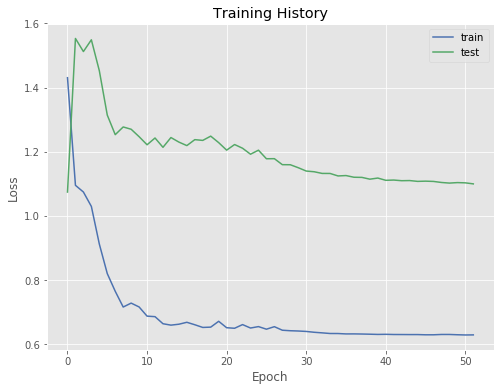

2016/2044 [============================>.] - ETA: 0s

AUC: 0.5


AUC: 0.34917



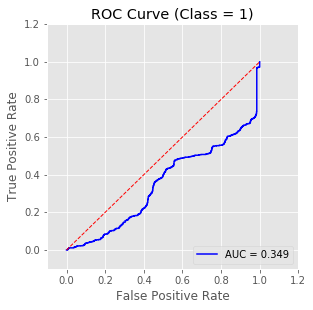

In [37]:
naive_score, fx_features_auc = do_one_model('CHF', feature_col_names = ['CH_FX', 'CH_BMP_Ratio'])

### All features

In [38]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('CH_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('CHF', feature_col_names = ['CH_FX'] + cols, do_pca = True)

In [39]:
all_results = accum_results(all_results, 'CHF', naive_score, fx_auc, fx_features_auc, fx_all_auc)

## UK

### FX rates only

Time period: 2000-01-03 - 2017-12-09


UK_FX

Scaled data shape: (6551, 1)
Reframed data shape: (6192, 181)


UK_FX(t-180),UK_FX(t-179),UK_FX(t-178),UK_FX(t-177),UK_FX(t-176),UK_FX(t-175),UK_FX(t-174),UK_FX(t-173),UK_FX(t-172),UK_FX(t-171),UK_FX(t-170),UK_FX(t-169),UK_FX(t-168),UK_FX(t-167),UK_FX(t-166),UK_FX(t-165),UK_FX(t-164),UK_FX(t-163),UK_FX(t-162),UK_FX(t-161),UK_FX(t-160),UK_FX(t-159),UK_FX(t-158),UK_FX(t-157),UK_FX(t-156),UK_FX(t-155),UK_FX(t-154),UK_FX(t-153),UK_FX(t-152),UK_FX(t-151),UK_FX(t-150),UK_FX(t-149),UK_FX(t-148),UK_FX(t-147),UK_FX(t-146),UK_FX(t-145),UK_FX(t-144),UK_FX(t-143),UK_FX(t-142),UK_FX(t-141),UK_FX(t-140),UK_FX(t-139),UK_FX(t-138),UK_FX(t-137),UK_FX(t-136),UK_FX(t-135),UK_FX(t-134),UK_FX(t-133),UK_FX(t-132),UK_FX(t-131),UK_FX(t-130),UK_FX(t-129),UK_FX(t-128),UK_FX(t-127),UK_FX(t-126),UK_FX(t-125),UK_FX(t-124),UK_FX(t-123),UK_FX(t-122),UK_FX(t-121),UK_FX(t-120),UK_FX(t-119),UK_FX(t-118),UK_FX(t-117),UK_FX(t-116),UK_FX(t-115),UK_FX(t-114),UK_FX(t-113),UK_FX(t-112),UK_FX(t-111),UK_FX(t-110),UK_FX(t-109),UK_FX(t-108),UK_FX(t-107),UK_FX(t-106),UK_FX(t-105),UK_FX(t-104),UK_FX(t-103),UK_FX(t-102),UK_FX(t-101),UK_FX(t-100),UK_FX(t-99),UK_FX(t-98),UK_FX(t-97),UK_FX(t-96),UK_FX(t-95),UK_FX(t-94),UK_FX(t-93),UK_FX(t-92),UK_FX(t-91),UK_FX(t-90),UK_FX(t-89),UK_FX(t-88),UK_FX(t-87),UK_FX(t-86),UK_FX(t-85),UK_FX(t-84),UK_FX(t-83),UK_FX(t-82),UK_FX(t-81),UK_FX(t-80),UK_FX(t-79),UK_FX(t-78),UK_FX(t-77),UK_FX(t-76),UK_FX(t-75),UK_FX(t-74),UK_FX(t-73),UK_FX(t-72),UK_FX(t-71),UK_FX(t-70),UK_FX(t-69),UK_FX(t-68),UK_FX(t-67),UK_FX(t-66),UK_FX(t-65),UK_FX(t-64),UK_FX(t-63),UK_FX(t-62),UK_FX(t-61),UK_FX(t-60),UK_FX(t-59),UK_FX(t-58),UK_FX(t-57),UK_FX(t-56),UK_FX(t-55),UK_FX(t-54),UK_FX(t-53),UK_FX(t-52),UK_FX(t-51),UK_FX(t-50),UK_FX(t-49),UK_FX(t-48),UK_FX(t-47),UK_FX(t-46),UK_FX(t-45),UK_FX(t-44),UK_FX(t-43),UK_FX(t-42),UK_FX(t-41),UK_FX(t-40),UK_FX(t-39),UK_FX(t-38),UK_FX(t-37),UK_FX(t-36),UK_FX(t-35),UK_FX(t-34),UK_FX(t-33),UK_FX(t-32),UK_FX(t-31),UK_FX(t-30),UK_FX(t-29),UK_FX(t-28),UK_FX(t-27),UK_FX(t-26),UK_FX(t-25),UK_FX(t-24),UK_FX(t-23),UK_FX(t-22),UK_FX(t-21),UK_FX(t-20),UK_FX(t-19),UK_FX(t-18),UK_FX(t-17),UK_FX(t-16),UK_FX(t-15),UK_FX(t-14),UK_FX(t-13),UK_FX(t-12),UK_FX(t-11),UK_FX(t-10),UK_FX(t-9),UK_FX(t-8),UK_FX(t-7),UK_FX(t-6),UK_FX(t-5),UK_FX(t-4),UK_FX(t-3),UK_FX(t-2),UK_FX(t-1),Is_Up
0.462052,0.473181,0.478188,0.484865,0.474738,0.474368,0.473997,0.473626,0.485422,0.483753,0.485644,0.471289,0.471789,0.472290,0.472791,0.474293,0.480748,0.491876,0.488093,0.488686,0.489280,0.489873,0.485644,0.475963,0.472402,0.455375,0.454336,0.453298,0.452259,0.448698,0.438682,0.434787,0.422546,0.422620,0.422695,0.422769,0.443690,0.444803,0.438349,0.423436,0.422212,0.420988,0.419764,0.426441,0.436457,0.437570,0.430225,0.433582,0.436939,0.440296,0.450367,0.437236,0.429891,0.421767,0.422769,0.423770,0.424772,0.407523,0.415201,0.405854,0.410861,0.407968,0.405075,0.402181,0.406633,0.415869,0.411418,0.408970,0.408561,0.408153,0.407745,0.401402,0.401959,0.403850,0.399176,0.398472,0.397767,0.397062,0.401402,0.399176,0.413087,0.421990,0.419950,0.417909,0.415869,0.417761,0.417538,0.423325,0.423325,0.425477,0.427628,0.429780,0.428110,0.420877,0.409748,0.413087,0.413013,0.412939,0.412864,0.417872,0.418874,0.418763,0.416426,0.416166,0.415906,0.415647,0.405742,0.407189,0.409860,0.408079,0.408636,0.409192,0.409748,0.408302,0.409192,0.403962,0.383040,0.382966,0.382892,0.382818,0.386379,0.388048,0.369130,0.352771,0.353587,0.354403,0.355219,0.355776,0.337748,0.320387,0.339862,0.336264,0.332666,0.329067,0.321611,0.310149,0.300467,0.304585,0.306514,0.308443,0.310372,0.290452,0.293456,0.287892,0.306811,0.308202,0.309593,0.310984,0.315157,0.317160,0.311262,0.329513,0.331590,0.333667,0.335744,0.346873,0.345760,0.327398,0.329513,0.331033,0.332554,0.334075,0.335188,0.323281,0.332183,0.339083,0.338675,0.338267,0.337859,0.331850,0.317383,0.332962,0.321834,0.321092,0.320350,0.319608,0.320721,0.332629,0.342310,0.335188,0
0.473181,0.478188,0.484865,0.474738,0.474368,0.473997,0.473626,0.485422,0.483753,0.485644,0.471289,0.471789,0.472290,0.472791,0.474293,0.480

(4148, 1, 180) (4148,) (2044, 1, 180) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
Epoch 00000: val_loss improved from inf to 1.95984, saving model to ./best_model.hdf5
1s - loss: 1.4265 - val_loss: 1.9598
Epoch 2/200
Epoch 00001: val_loss did not improve
1s - loss: 1.5105 - val_loss: 2.0379
Epoch 3/200
Epoch 00002: val_loss improved from 1.95984 to 1.45089, saving model to ./best_model.hdf5
1s - loss: 1.4032 - val_loss: 1.4509
Epoch 4/200
Epoch 00003: val_loss improved from 1.45089 to 1.20796, saving model to ./best_model.hdf5
1s - loss: 1.0597 - val_loss: 1.2080
Epoch 5/200
Epoch 00004: val_loss improved from 1.20796 to 1.18233, saving model to ./best_model.hdf5
1s - loss: 1.0433 - val_loss: 1.1823
Epoch 6/200
Epoch 00005: val_loss improved from 1.18233 to 1.12195, saving model to ./best_model.hdf5
1s - loss: 1.0311 - val_loss: 1.1220
Epoch 7/200
Epoch 00006: val_loss improved from 1.12195 to 0.98498, saving model to ./best_model.hdf5
1s - loss: 0.9631 - val_loss: 0.9850
Epoch 8/200
Epoch 00007: val_loss d

Epoch 00081: val_loss did not improve
1s - loss: 0.7459 - val_loss: 0.7847
Epoch 83/200
Epoch 00082: val_loss did not improve
1s - loss: 0.7459 - val_loss: 0.7839
Epoch 84/200
Epoch 00083: val_loss did not improve
1s - loss: 0.7442 - val_loss: 0.7818
Epoch 85/200
Epoch 00084: val_loss did not improve
1s - loss: 0.7430 - val_loss: 0.7840
Epoch 86/200
Epoch 00085: val_loss did not improve
1s - loss: 0.7456 - val_loss: 0.7853
Epoch 87/200
Epoch 00086: val_loss did not improve
1s - loss: 0.7442 - val_loss: 0.7835
Epoch 88/200
Epoch 00087: val_loss did not improve
1s - loss: 0.7442 - val_loss: 0.7837
Epoch 89/200
Epoch 00088: val_loss did not improve
1s - loss: 0.7429 - val_loss: 0.7818
Epoch 90/200
Epoch 00089: val_loss did not improve
1s - loss: 0.7430 - val_loss: 0.7841
Epoch 91/200
Epoch 00090: val_loss did not improve
1s - loss: 0.7434 - val_loss: 0.7816
Epoch 92/200
Epoch 00091: val_loss did not improve
1s - loss: 0.7426 - val_loss: 0.7824
Epoch 93/200
Epoch 00092: val_loss did not im

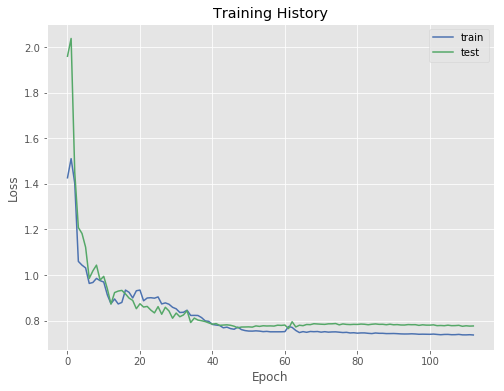

1056/2044 [==============>...............] - ETA: 0s 

AUC: 0.5


AUC: 0.77854



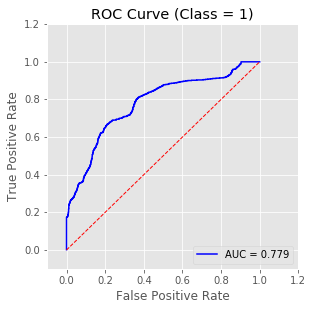

In [40]:
naive_score, fx_auc = do_one_model('GBP', feature_col_names = ['UK_FX'], verbose = 2)

### FX rates and other features

Time period: 2000-01-03 - 2017-12-09


UK_FX, UK_BMP_Ratio

Scaled data shape: (6551, 2)
Reframed data shape: (6192, 361)


UK_FX(t-180),UK_BMP_Ratio(t-180),UK_FX(t-179),UK_BMP_Ratio(t-179),UK_FX(t-178),UK_BMP_Ratio(t-178),UK_FX(t-177),UK_BMP_Ratio(t-177),UK_FX(t-176),UK_BMP_Ratio(t-176),UK_FX(t-175),UK_BMP_Ratio(t-175),UK_FX(t-174),UK_BMP_Ratio(t-174),UK_FX(t-173),UK_BMP_Ratio(t-173),UK_FX(t-172),UK_BMP_Ratio(t-172),UK_FX(t-171),UK_BMP_Ratio(t-171),UK_FX(t-170),UK_BMP_Ratio(t-170),UK_FX(t-169),UK_BMP_Ratio(t-169),UK_FX(t-168),UK_BMP_Ratio(t-168),UK_FX(t-167),UK_BMP_Ratio(t-167),UK_FX(t-166),UK_BMP_Ratio(t-166),UK_FX(t-165),UK_BMP_Ratio(t-165),UK_FX(t-164),UK_BMP_Ratio(t-164),UK_FX(t-163),UK_BMP_Ratio(t-163),UK_FX(t-162),UK_BMP_Ratio(t-162),UK_FX(t-161),UK_BMP_Ratio(t-161),UK_FX(t-160),UK_BMP_Ratio(t-160),UK_FX(t-159),UK_BMP_Ratio(t-159),UK_FX(t-158),UK_BMP_Ratio(t-158),UK_FX(t-157),UK_BMP_Ratio(t-157),UK_FX(t-156),UK_BMP_Ratio(t-156),UK_FX(t-155),UK_BMP_Ratio(t-155),UK_FX(t-154),UK_BMP_Ratio(t-154),UK_FX(t-153),UK_BMP_Ratio(t-153),UK_FX(t-152),UK_BMP_Ratio(t-152),UK_FX(t-151),UK_BMP_Ratio(t-151),UK_FX(t-150),UK_BMP_Ratio(t-150),UK_FX(t-149),UK_BMP_Ratio(t-149),UK_FX(t-148),UK_BMP_Ratio(t-148),UK_FX(t-147),UK_BMP_Ratio(t-147),UK_FX(t-146),UK_BMP_Ratio(t-146),UK_FX(t-145),UK_BMP_Ratio(t-145),UK_FX(t-144),UK_BMP_Ratio(t-144),UK_FX(t-143),UK_BMP_Ratio(t-143),UK_FX(t-142),UK_BMP_Ratio(t-142),UK_FX(t-141),UK_BMP_Ratio(t-141),UK_FX(t-140),UK_BMP_Ratio(t-140),UK_FX(t-139),UK_BMP_Ratio(t-139),UK_FX(t-138),UK_BMP_Ratio(t-138),UK_FX(t-137),UK_BMP_Ratio(t-137),UK_FX(t-136),UK_BMP_Ratio(t-136),UK_FX(t-135),UK_BMP_Ratio(t-135),UK_FX(t-134),UK_BMP_Ratio(t-134),UK_FX(t-133),UK_BMP_Ratio(t-133),UK_FX(t-132),UK_BMP_Ratio(t-132),UK_FX(t-131),UK_BMP_Ratio(t-131),UK_FX(t-130),UK_BMP_Ratio(t-130),UK_FX(t-129),UK_BMP_Ratio(t-129),UK_FX(t-128),UK_BMP_Ratio(t-128),UK_FX(t-127),UK_BMP_Ratio(t-127),UK_FX(t-126),UK_BMP_Ratio(t-126),UK_FX(t-125),UK_BMP_Ratio(t-125),UK_FX(t-124),UK_BMP_Ratio(t-124),UK_FX(t-123),UK_BMP_Ratio(t-123),UK_FX(t-122),UK_BMP_Ratio(t-122),UK_FX(t-121),UK_BMP_Ratio(t-121),UK_FX(t-120),UK_BMP_Ratio(t-120),UK_FX(t-119),UK_BMP_Ratio(t-119),UK_FX(t-118),UK_BMP_Ratio(t-118),UK_FX(t-117),UK_BMP_Ratio(t-117),UK_FX(t-116),UK_BMP_Ratio(t-116),UK_FX(t-115),UK_BMP_Ratio(t-115),UK_FX(t-114),UK_BMP_Ratio(t-114),UK_FX(t-113),UK_BMP_Ratio(t-113),UK_FX(t-112),UK_BMP_Ratio(t-112),UK_FX(t-111),UK_BMP_Ratio(t-111),UK_FX(t-110),UK_BMP_Ratio(t-110),UK_FX(t-109),UK_BMP_Ratio(t-109),UK_FX(t-108),UK_BMP_Ratio(t-108),UK_FX(t-107),UK_BMP_Ratio(t-107),UK_FX(t-106),UK_BMP_Ratio(t-106),UK_FX(t-105),UK_BMP_Ratio(t-105),UK_FX(t-104),UK_BMP_Ratio(t-104),UK_FX(t-103),UK_BMP_Ratio(t-103),UK_FX(t-102),UK_BMP_Ratio(t-102),UK_FX(t-101),UK_BMP_Ratio(t-101),UK_FX(t-100),UK_BMP_Ratio(t-100),UK_FX(t-99),UK_BMP_Ratio(t-99),UK_FX(t-98),UK_BMP_Ratio(t-98),UK_FX(t-97),UK_BMP_Ratio(t-97),UK_FX(t-96),UK_BMP_Ratio(t-96),UK_FX(t-95),UK_BMP_Ratio(t-95),UK_FX(t-94),UK_BMP_Ratio(t-94),UK_FX(t-93),UK_BMP_Ratio(t-93),UK_FX(t-92),UK_BMP_Ratio(t-92),UK_FX(t-91),UK_BMP_Ratio(t-91),UK_FX(t-90),UK_BMP_Ratio(t-90),UK_FX(t-89),UK_BMP_Ratio(t-89),UK_FX(t-88),UK_BMP_Ratio(t-88),UK_FX(t-87),UK_BMP_Ratio(t-87),UK_FX(t-86),UK_BMP_Ratio(t-86),UK_FX(t-85),UK_BMP_Ratio(t-85),UK_FX(t-84),UK_BMP_Ratio(t-84),UK_FX(t-83),UK_BMP_Ratio(t-83),UK_FX(t-82),UK_BMP_Ratio(t-82),UK_FX(t-81),UK_BMP_Ratio(t-81),UK_FX(t-80),UK_BMP_Ratio(t-80),UK_FX(t-79),UK_BMP_Ratio(t-79),UK_FX(t-78),UK_BMP_Ratio(t-78),UK_FX(t-77),UK_BMP_Ratio(t-77),UK_FX(t-76),UK_BMP_Ratio(t-76),UK_FX(t-75),UK_BMP_Ratio(t-75),UK_FX(t-74),UK_BMP_Ratio(t-74),UK_FX(t-73),UK_BMP_Ratio(t-73),UK_FX(t-72),UK_BMP_Ratio(t-72),UK_FX(t-71),UK_BMP_Ratio(t-71),UK_FX(t-70),UK_BMP_Ratio(t-70),UK_FX(t-69),UK_BMP_Ratio(t-69),UK_FX(t-68),UK_BMP_Ratio(t-68),UK_FX(t-67),UK_BMP_Ratio(t-67),UK_FX(t-66),UK_BMP_Ratio(t-66),UK_FX(t-65),UK_BMP_Ratio(t-65),UK_FX(t-64),UK_BMP_Ratio(t-64),UK_FX(t-63),UK_BMP_Ratio(t-63),UK_FX(t-62),UK_BMP_Ratio(t-62),UK_FX(t-61),UK_BMP_Ratio(t-61),UK_FX(t-60),UK_BMP_Ratio(t-60),UK_FX(t-59),UK_BMP_Ratio(t-59),UK_FX(t-58),UK_BMP_Ratio(t-58),UK_FX(t-57),UK_BMP_Ratio(

(4148, 1, 360) (4148,) (2044, 1, 360) (2044,)


Train on 4148 samples, validate on 2044 samples
Epoch 1/200
Epoch 00000: val_loss improved from inf to 2.18813, saving model to ./best_model.hdf5
1s - loss: 1.5425 - val_loss: 2.1881
Epoch 2/200
Epoch 00001: val_loss improved from 2.18813 to 1.64712, saving model to ./best_model.hdf5
1s - loss: 1.5566 - val_loss: 1.6471
Epoch 3/200
Epoch 00002: val_loss did not improve
1s - loss: 1.6388 - val_loss: 1.9214
Epoch 4/200
Epoch 00003: val_loss did not improve
1s - loss: 1.5955 - val_loss: 1.7147
Epoch 5/200
Epoch 00004: val_loss improved from 1.64712 to 1.41227, saving model to ./best_model.hdf5
1s - loss: 1.4118 - val_loss: 1.4123
Epoch 6/200
Epoch 00005: val_loss did not improve
1s - loss: 1.4319 - val_loss: 1.4540
Epoch 7/200
Epoch 00006: val_loss improved from 1.41227 to 1.33067, saving model to ./best_model.hdf5
1s - loss: 1.3715 - val_loss: 1.3307
Epoch 8/200
Epoch 00007: val_loss did not improve
1s - loss: 1.3719 - val_loss: 1.4388
Epoch 9/200
Epoch 00008: val_loss improved from 1.33

Epoch 00080: val_loss did not improve
1s - loss: 0.7715 - val_loss: 0.8494
Epoch 82/200
Epoch 00081: val_loss did not improve
1s - loss: 0.7857 - val_loss: 0.8449
Epoch 83/200
Epoch 00082: val_loss did not improve
1s - loss: 0.7826 - val_loss: 0.8303
Epoch 84/200
Epoch 00083: val_loss did not improve
1s - loss: 0.7824 - val_loss: 0.8413
Epoch 85/200
Epoch 00084: val_loss improved from 0.82131 to 0.81931, saving model to ./best_model.hdf5
1s - loss: 0.8127 - val_loss: 0.8193
Epoch 86/200
Epoch 00085: val_loss improved from 0.81931 to 0.81382, saving model to ./best_model.hdf5
1s - loss: 0.7610 - val_loss: 0.8138
Epoch 87/200
Epoch 00086: val_loss did not improve
1s - loss: 0.7976 - val_loss: 0.8413
Epoch 88/200
Epoch 00087: val_loss did not improve
1s - loss: 0.7952 - val_loss: 0.8319
Epoch 89/200
Epoch 00088: val_loss did not improve
1s - loss: 0.8078 - val_loss: 0.8374
Epoch 90/200
Epoch 00089: val_loss did not improve
1s - loss: 0.8121 - val_loss: 0.8346
Epoch 91/200
Epoch 00090: val

Epoch 00167: val_loss did not improve
1s - loss: 0.7375 - val_loss: 0.8050
Epoch 169/200
Epoch 00168: val_loss did not improve
1s - loss: 0.7309 - val_loss: 0.8063
Epoch 170/200
Epoch 00169: val_loss did not improve
1s - loss: 0.7362 - val_loss: 0.8081
Epoch 171/200
Epoch 00170: val_loss did not improve
1s - loss: 0.7375 - val_loss: 0.8053
Epoch 172/200
Epoch 00171: val_loss improved from 0.80212 to 0.79852, saving model to ./best_model.hdf5
1s - loss: 0.7299 - val_loss: 0.7985
Epoch 173/200
Epoch 00172: val_loss did not improve
1s - loss: 0.7307 - val_loss: 0.8039
Epoch 174/200
Epoch 00173: val_loss did not improve
1s - loss: 0.7295 - val_loss: 0.8027
Epoch 175/200
Epoch 00174: val_loss did not improve
1s - loss: 0.7313 - val_loss: 0.8054
Epoch 176/200
Epoch 00175: val_loss did not improve
1s - loss: 0.7270 - val_loss: 0.7991
Epoch 177/200
Epoch 00176: val_loss did not improve
1s - loss: 0.7468 - val_loss: 0.8114
Epoch 178/200
Epoch 00177: val_loss did not improve
1s - loss: 0.7393 - 

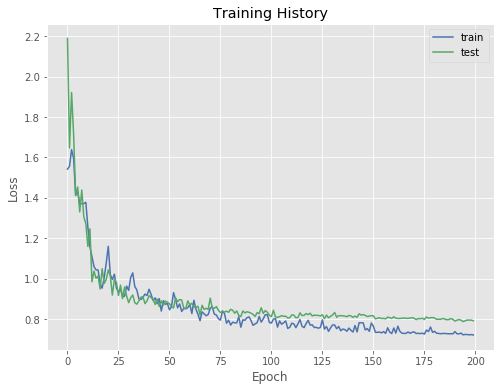

1984/2044 [============================>.] - ETA: 0s

AUC: 0.5


AUC: 0.60747



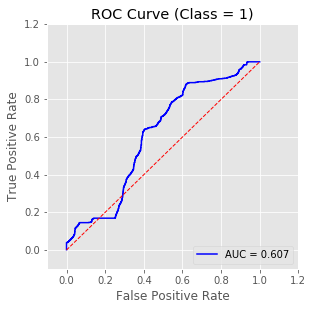

In [41]:
naive_score, fx_features_auc = do_one_model('GBP', feature_col_names = ['UK_FX', 'UK_BMP_Ratio'])

### All features

In [42]:
cols = [feature_cols[i] for i in range(n_feature_cols) 
        if re.search('UK_FX', feature_cols[i]) == None]
naive_score, fx_all_auc = do_one_model('GBP', feature_col_names = ['UK_FX'] + cols, do_pca = True)

In [43]:
all_results = accum_results(all_results, 'GBP', naive_score, fx_auc, fx_features_auc, fx_all_auc)

# Summary of results

#### Test AUC for all FX rates (relative to USD)

In [44]:
all_results = all_results[['Currency', 'Naive', 'FX Only', 'FX + Features', 'All Features']]
all_results.to_csv('AUC_LSTM_7.csv', index = False)

pd.options.display.float_format = '{:,.5f}'.format
my_linespace()
my_display_df(all_results)

Currency,Naive,FX Only,FX + Features,All Features
AUD,None,0.74067,0.70942,None
CAD,None,0.68016,0.70902,None
JPY,None,0.19403,0.49896,None
CHF,None,0.57046,0.34917,None
GBP,None,0.77854,0.60747,None


#### Visualize test AUC

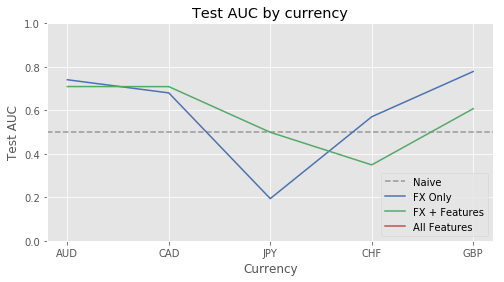

In [45]:
n_items = all_results.shape[0]

print()
fig, ax = plt.subplots(figsize = (8, 4))

ax.axhline(y = 0.5, color = '0.6', linestyle = '--', label = 'Naive')

ax.plot(range(n_items), all_results['FX Only'], label = 'FX Only')
ax.plot(range(n_items), all_results['FX + Features'], label = 'FX + Features')
ax.plot(range(n_items), all_results['All Features'], label = 'All Features')

ax.set_ylim((0.0, 1.0))
ax.set_xticks(range(n_items))
ax.set_xticklabels(all_results['Currency'])

ax.set_xlabel('Currency')
ax.set_ylabel('Test AUC')
ax.set_title('Test AUC by currency')

plt.legend(loc = 'lower right')
plt.show()

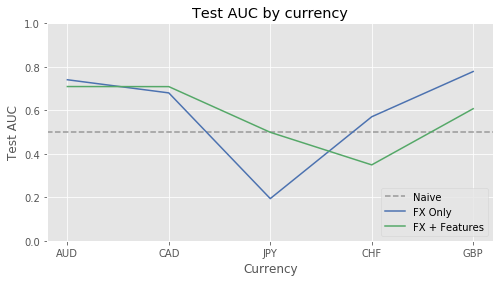

In [46]:
n_items = all_results.shape[0]

print()
fig, ax = plt.subplots(figsize = (8, 4))

ax.axhline(y = 0.5, color = '0.6', linestyle = '--', label = 'Naive')

ax.plot(range(n_items), all_results['FX Only'], label = 'FX Only')
ax.plot(range(n_items), all_results['FX + Features'], label = 'FX + Features')
#ax.plot(range(n_items), all_results['All Features'], label = 'All Features')

ax.set_ylim((0.0, 1.0))
ax.set_xticks(range(n_items))
ax.set_xticklabels(all_results['Currency'])

ax.set_xlabel('Currency')
ax.set_ylabel('Test AUC')
ax.set_title('Test AUC by currency')

plt.legend(loc = 'lower right')
plt.show()